# Multi-Task U-Net (Xception-Style) Training and Evaluation

This notebook implements and trains a prototype **Multi-Task Learning (MTL)** model on the COVID-19 X-ray dataset. The model is designed to simultaneously solve two related computer vision tasks: **image segmentation** and **image classification**.

---

## Core Methodology

### 1. U-Net Architecture (Segmentation Head)
The foundational architecture is a **U-Net** variant built using the powerful Xception convolutional base as its encoder. This design choice is inspired by the official Keras documentation on image segmentation [U-Net Xception Style](https://keras.io/examples/vision/oxford_pets_image_segmentation/). 

* **Encoder:** Uses Xception blocks (a feature extraction network) to efficiently downsample the input image and capture high-level features.
* **Decoder:** Uses upsampling layers (e.g., `Conv2DTranspose` or simple upsampling + convolution) combined with skip connections from the encoder to reconstruct the segmented mask at high resolution.

### 2. Multi-Task Classification Head (Prototype)
A separate classification branch is added to the model's bottleneck or final encoder output. This head is designed for a **4-class classification** task (COVID, Normal, Viral Pneumonia, Lung Opacity), contrasting with the project's final binary classification goal.

* **Objective:** To investigate the potential of a single model simultaneously learning both pixel-level localization (segmentation) and image-level diagnosis (classification).
* **Status:** As noted, this multi-task approach served as a prototype and did not yield optimal classification results, but the shared encoder and segmentation head training were successful and retained for the project.

### 3. Data Pipeline and Training
The notebook utilizes the pre-sharded TFRecord files created in the previous step, setting up a high-performance `tf.data` pipeline. The model is trained to minimize a combined loss function, addressing both segmentation and classification errors concurrently.

The primary and successful output of this notebook is a well-trained **segmentation model**, ready for deployment in the first stage of the overall COVID analysis pipeline (which often involves segmenting the lung area before classification).

## Section 1: Environment Setup and Distribution Strategy

This initial section focuses on configuring the notebook's execution environment. It imports all necessary libraries for deep learning (TensorFlow, Keras layers, NumPy, etc.), ensures reproducibility by setting global seeds, and establishes the optimal hardware distribution strategy (TPU, GPU, or CPU) for efficient multi-task model training.

---

### 1.1 Library Imports and Version Check

This subsection imports the comprehensive set of tools required for building, training, and managing the multi-task model.

* **Core ML Frameworks:** Imports `tensorflow` (`tf`), `numpy` (`np`), `random`, and `os`.
* **Keras/Layer Components:** Imports `tensorflow.keras.layers` (`tfl`), `tensorflow.keras.backend` (`K`), and `tensorflow.keras.metrics`.
* **Utilities:** Imports `math` and `matplotlib.pyplot` (`plt`) for numerical operations and visualization.
* **Version Check:** The TensorFlow version is explicitly printed to confirm compatibility with expected features (e.g., advanced augmentation techniques).

In [16]:
#Import necessary libraries
import tensorflow as tf
import numpy as np
import random
import os
import math
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

In [17]:
# Check TensorFlow Version
print(tf.__version__)

2.20.0


---
### 1.2 Reproducibility and Utility Functions

This subsection defines helper functions to ensure the training run is deterministic and to initialize the environment's state.

#### 1.2.1 `seed_everthing` Function
This function sets the random seeds across all major components (`tf`, `np`, `random`) to a fixed value (defaulting to 28). This is a best practice to ensure that model weight initialization, data shuffling, and other stochastic processes are identical across runs, making experiments reproducible.

#### 1.2.2 `get_strategy` Function and Distribution Strategy Activation
This function automatically detects the best available hardware accelerator and configures the corresponding TensorFlow Distribution Strategy for parallel computation.

* **TPU Priority:** It first attempts to initialize and connect to a TPU using `TPUClusterResolver` and `tf.distribute.TPUStrategy`.
* **GPU Fallback:** If a TPU is not found, it checks for available GPUs and uses `tf.distribute.MirroredStrategy`, which is optimal for multi-GPU training.
* **CPU Default:** If neither TPU nor GPU is available, it defaults to the standard strategy.
* **Activation:** The function is called, and the resulting `strategy` object is stored. The number of active replicas (cores/GPUs) is printed, confirming the multi-device setup for training.

In [18]:
def seed_everthing(SEED= 28):
    """
    Sets the global random seeds for reproducibility across TensorFlow, NumPy, and Python's random module.
    
    Args:
        SEED (int): The integer seed value to be used.
    """
    # Set the seed for TensorFlow operations (both CPU and GPU)
    tf.random.set_seed(SEED)
    # Set the seed for NumPy's random number generator
    np.random.seed(SEED)
    # Set the seed for Python's built-in random module
    random.seed(SEED)

In [19]:
def get_strategy():
    """
    Detects and returns the best TensorFlow distribution strategy.
    - TPUStrategy for TPU(s)
    - MirroredStrategy for GPU(s)
    - Default strategy for CPU
    """
    try:
        # Try TPU first
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Using TPU strategy:", type(strategy).__name__)
    except Exception:
        # If TPU not available, try GPU
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            strategy = tf.distribute.MirroredStrategy()
            print("Using GPU strategy:", type(strategy).__name__)
        else:
            # Fallback CPU
            strategy = tf.distribute.get_strategy()
            print("No TPU/GPU found. Using CPU strategy:", type(strategy).__name__)

    print("REPLICAS:", strategy.num_replicas_in_sync)
    return strategy

# Call it
strategy = get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU strategy: MirroredStrategy
REPLICAS: 1


---
### 1.3 Hyperparameter and Global Constant Configuration

This subsection defines the critical hyperparameters and global constants that govern the data pipeline setup and the model training process. These values are essential for managing resource allocation, tensor dimensions, and learning dynamics, especially in a distributed training environment.

| Constant | Value | Description |
| :--- | :--- | :--- |
| **`AUTO`** | `tf.data.AUTOTUNE` | Used for dynamic optimization of CPU threads in the data input pipeline. |
| **`IMAGE_SIZE`** | `(256, 256)` | The target spatial dimension for image resizing. |
| **`MASK_SIZE`** | `(256, 256)` | The target spatial dimension for mask resizing, matching the image size. |
| **`SHUFFLE_SIZE`** | `1024` | The buffer size used for shuffling the dataset, balancing randomness with memory usage. |
| **`LEARNING_RATE`** | `1e-3` | The initial learning rate for the optimizer. |
| **`NUM_CLASSES`** | `4` | Defines the number of output classes for the classification head (COVID, Normal, Viral Pneumonia, Lung Opacity). |
| **`BATCH_SIZE_PER_REPLICA`** | `8` | The batch size processed by each individual TPU core or GPU. |
| **`GLOBAL_BATCH_SIZE`** | Calculated | The total effective batch size across all available hardware replicas, calculated as `BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync`. |

The output confirms the effective batch size for distributed training:
> `Global Batch size: [Calculated Value]`

In [53]:
AUTO = tf.data.AUTOTUNE
IMAGE_SIZE = (256, 256)
MASK_SIZE = IMAGE_SIZE
SHUFFLE_SIZE = 1024
LEARNING_RATE = 1e-3
NUM_CLASSES = 4
BATCH_SIZE_PER_REPLICA = 8
GLOBAL_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
print(f'Global Batch size: {GLOBAL_BATCH_SIZE}')

Global Batch size: 8


## Section 2: Data Augmentation and Input Pipeline Definition

This section is critical for preparing the data to be consumed by the multi-task model. It defines the dynamic on-the-fly augmentation layers, the core function for parsing the TFRecord data, and the crucial `augment` function that applies geometric transformations synchronously to both the image and its corresponding segmentation mask.

---

### 2.1 Augmentation Layers Definition

The augmentation pipeline is separated into two sequential layers, both configured to use interpolation methods that preserve the structural integrity of the segmentation masks (which are binary data).

#### 2.1.1 Geometric Augmentation (`geometric_augmentation`)
This `tf.keras.Sequential` layer applies a set of standard spatial transformations. All operations use `interpolation='nearest'` and `fill_mode='nearest'` to ensure that pixel values in the mask (0 or 1) are not interpolated to non-binary values.
* **RandomFlip** (`horizontal`)
* **RandomRotation** (up to $\pm 5\%$)
* **RandomTranslation** (up to $\pm 5\%$ height/width factor)
* **RandomZoom** (up to $10\%$)

#### 2.1.2 Elastic Augmentation (`elastic_augmentation`)
This custom layer applies randomized, non-linear geometric deformation, which is effective for increasing model robustness to subtle variations in organ shape. It is configured with a factor of $1.0$ and a scale of $0.1$, also using `interpolation='nearest'`.

In [21]:
# Define a Sequential model for standard geometric augmentations
geometric_augmentation = tf.keras.Sequential([
    # Randomly flip the input horizontally
    tf.keras.layers.RandomFlip('horizontal'),
    
    # Randomly rotate the input by a factor between -0.05 and 0.05 radians
    tf.keras.layers.RandomRotation((-0.05, 0.05), interpolation= 'nearest', fill_mode= 'nearest'),
    
    # Randomly translate the image both horizontally and vertically
    tf.keras.layers.RandomTranslation(height_factor= (-0.05, 0.05), 
                                      width_factor= (-0.05, 0.05), 
                                      interpolation= 'nearest', fill_mode= 'nearest'),
    
    # Randomly zoom in or out by up to 10%
    tf.keras.layers.RandomZoom(0.1, interpolation= 'nearest', fill_mode= 'nearest')
], name= 'geometric_augmentation')

# Define a layer for elastic deformation augmentation
elastic_augmentation = tf.keras.layers.RandomElasticTransform(
    factor= 1.0,  # Intensity of the random displacement
    scale= 0.1,   # Scale of the grid used for the transformation
    interpolation= 'nearest' # Use nearest neighbor interpolation (essential for masks)
)

### 2.2 TFRecord Parsing and Preprocessing (`parse_tfrecord_function`)

This function handles the deserialization of the TFRecord data, converting raw bytes into normalized and resized tensors, and preparing the output for the two model heads.

* **Deserialization:** It reads the `image` (3-channel), `mask` (1-channel), and `class` (`int64`) features.
* **Image Preprocessing:** The image is cast to `float32`, normalized to the $[0, 1]$ range, and resized to `IMAGE_SIZE` (256x256) using **bilinear** interpolation.
* **Mask Preprocessing:** The mask is also cast to `float32`, normalized, and resized to `MASK_SIZE` using **nearest** neighbor interpolation to maintain its discrete binary nature. A final `tf.round` is applied to ensure binary values.
* **Multi-Task Output:** The function formats the output as a tuple: `(image, {'segmentation': mask, 'classification': label_one_hot})`. The integer label is converted to **one-hot encoding** (`tf.one_hot`) with a depth of `NUM_CLASSES=4` for the classification head.

In [22]:
def parse_tfrecord_function(example):
    """
    Parses a single serialized TFRecord example, extracts image, mask, and class label,
    decodes them, normalizes, and resizes them for model input.
    """
    # Define the structure and data types of the features stored in the TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64)
    }
    
    # Parse the example string into a dictionary of tensors
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the PNG encoded image (3 color channels)
    image = tf.io.decode_png(example['image'], channels= 3)
    # Decode the PNG encoded mask (1 grayscale channel)
    mask = tf.io.decode_png(example['mask'], channels= 1)
    # Extract the scalar class label
    label = example['class']
    
    # --- Process Image ---
    # Cast image to float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.
    # Resize image to the target input size using bilinear interpolation
    image = tf.image.resize(image, IMAGE_SIZE, method= 'bilinear')
    
    # --- Process Mask ---
    # Cast mask to float32 and normalize
    mask = tf.cast(mask, tf.float32) / 255.
    # Resize mask to the target output size using 'nearest' neighbor interpolation (critical for masks)
    mask = tf.image.resize(mask, MASK_SIZE, method= 'nearest')
    # Round the mask values to ensure it remains strictly binary (0 or 1)
    mask = tf.round(mask)
    
    # Return the processed image and a dictionary of targets for the multi-task model
    return image, {
        'segmentation': mask,
        # Convert scalar label into a one-hot encoded vector
        'classification': tf.one_hot(label, depth= NUM_CLASSES)
    }

### 2.3 Multi-Task Augmentation Pipeline (`augment` function)

This function implements the essential logic for **synchronous geometric augmentation**, which is mandatory when training segmentation models, as the mask must be transformed identically to the image.

* **Concatenation:** The input image (3 channels) and mask (1 channel) are concatenated along the last axis (`axis=-1`) to form a single 4-channel tensor (`combined`).
* **Simultaneous Transformation:** The `geometric_augmentation` and `elastic_augmentation` layers are applied to this combined tensor.
* **Splitting:** The augmented tensor (`combined_aug`) is split back into the augmented image (3 channels) and the augmented mask (1 channel).
* **Finalization:** The augmented mask is re-rounded (`tf.round`) to strictly enforce binary values (0 or 1).
* The function returns the image and the target dictionary in the expected multi-task format.

In [23]:
def augment(image, targets):
    """
    Applies geometric and elastic augmentations to the image and its corresponding mask 
    for training stability and robustness.
    
    Args:
        image (tensor): The input image tensor.
        targets (dict): Dictionary containing the 'segmentation' mask and 'classification' label.

    Returns:
        tuple: Augmented image and targets dictionary.
    """
    # Extract the mask and label from the targets dictionary
    mask = targets['segmentation']
    label = targets['classification']
    
    # Concatenate the image (3 channels) and mask (1 channel) along the channel axis for synchronized augmentation
    combined = tf.concat([image, mask], axis= -1)
    
    # Apply geometric augmentations (e.g., rotation, flip)
    combined_aug = geometric_augmentation(combined, training= True)
    
    # Apply elastic augmentations (e.g., slight deformations)
    combined_aug = elastic_augmentation(combined_aug, training= True)
    
    # Split the augmented combined tensor back into the augmented image and mask
    img_aug, mask_aug = tf.split(combined_aug, 
                                 # Split into 3 channels for image and 1 channel for mask
                                 num_or_size_splits= [3, 1],
                                 axis= -1)
    
    # Round the augmented mask values to maintain binary (0 or 1) nature after interpolation
    mask_aug = tf.round(mask_aug)
    
    # Return the augmented image and the updated targets dictionary
    return img_aug, {
        'segmentation': mask_aug,
        'classification': label
    }

## Section 3: TFRecord Loading and Data Input Pipeline

This section defines the crucial logic for reading the pre-sharded TFRecord files, splitting the dataset into training and validation sets, and constructing the highly optimized `tf.data.Dataset` pipeline for distributed multi-task training.

---

### 3.1 Data Splitting and File Allocation

The full set of sharded TFRecord files is located and then partitioned into training and validation groups.

* **File Discovery:** It uses `tf.io.gfile.glob` to retrieve all `.tfrecord` files from the specified `DATA_DIR` (`./data/tfrecords/`).
* **Train/Validation Split:** The dataset is split into a $90\% / 10\%$ ratio:
    * **Training Files:** Uses the first 9 files (`all_files[:-1]`).
    * **Validation Files:** Uses the last file (`all_files[-1:]`).

In [24]:
# Define the directory where the TFRecord files are stored
DATA_DIR = '../data/tfrecords/'
# Search for all files ending with '.tfrecord' in the specified directory and sort them
all_files = sorted(tf.io.gfile.glob(os.path.join(DATA_DIR, '*.tfrecord')))

In [ ]:
# Assign all files EXCEPT the last one to the training set
train_files = all_files[:-1]
# Assign only the LAST file to the validation set
val_files = all_files[-1:]

### 3.2 High-Performance Data Pipeline Definition (`dataset` function)

The `dataset` function constructs the final, optimized `tf.data.Dataset` object tailored for training or validation. 

* **Parallelism and Determinism:** It enables non-deterministic reading (`ignore_order.experimental_deterministic = False`) and uses `num_parallel_reads=AUTO` for maximum I/O efficiency when reading the TFRecords.
* **Core Mapping:** The `parse_tfrecord_function` (from Section 2) is applied to deserialize and preprocess each record.
* **Training Pipeline (`is_training=True`):**
    1.  **Shuffle:** Applies a dataset shuffle with a buffer size of `SHUFFLE_SIZE`.
    2.  **Batching:** Batches the data first (`dataset.batch(...)`).
    3.  **Augmentation:** Maps the `augment` function *after* batching, enabling efficient, vectorized augmentation on the CPU/host machine.
* **Validation Pipeline (`is_training=False`):**
    1.  **Batching:** Only batches the data without shuffling or augmenting.
* **Prefetching:** Uses `dataset.prefetch(AUTO)` to ensure the next batch of data is always ready on the device while the current batch is being processed.

The training and validation datasets (`train_dataset` and `val_dataset`) are instantiated using this function.

In [41]:
def dataset(tfrecords, batch_size= GLOBAL_BATCH_SIZE, shuffle_size= SHUFFLE_SIZE, is_training= True):
    """
    Creates a highly optimized TensorFlow Dataset pipeline for training or validation 
    from a list of TFRecord files.
    """
    # Create an options object to enable non-deterministic data reading (better performance)
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    # Load the TFRecords, reading multiple files in parallel (AUTO)
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads= AUTO)
    # Apply the non-deterministic reading option
    dataset = dataset.with_options(ignore_order)
    
    # Parse the serialized TFRecord data into image, mask, and label tensors
    dataset = dataset.map(parse_tfrecord_function, num_parallel_calls= AUTO)
    
    # --- Training Pipeline ---
    if is_training:
        # Shuffle the samples before batching for better generalization
        dataset = dataset.shuffle(shuffle_size)
        # 1. Batch the data FIRST (mandatory for batched augmentation/TPU)
        dataset = dataset.batch(batch_size, drop_remainder= True)
        # 2. Apply augmentation to the entire batch SECOND
        dataset = dataset.map(lambda img, targets: augment(img, targets), num_parallel_calls= AUTO)
    
    # --- Validation/Test Pipeline ---
    else:
        # For validation, just batch the data without augmenting
        dataset = dataset.batch(batch_size, drop_remainder= True)
        
    # 3. Prefetch augmented/batched data to overlap data preparation and model execution
    dataset = dataset.prefetch(AUTO)
    return dataset

In [42]:
train_dataset = dataset(train_files, is_training= True)
val_dataset = dataset(val_files, is_training= False)

### 3.3 Sample Counting and Epoch Steps Calculation

Before training begins, the total number of samples is counted, and the `steps_per_epoch` are calculated based on the `GLOBAL_BATCH_SIZE`.

* **`count_tfrecord` Function:** This utility iterates through all records in the assigned TFRecord files to get an exact count of training and validation samples.
* **Calculation:**
    * `train_samples`: Total number of training records.
    * `val_samples`: Total number of validation records.
    * `steps_per_epoch`: Calculated as $\lceil \text{train\_samples} / \text{GLOBAL\_BATCH\_SIZE} \rceil$.
    * `validation_steps`: Calculated as $\lceil \text{val\_samples} / \text{GLOBAL\_BATCH\_SIZE} \rceil$.

This ensures the Keras `model.fit()` function correctly defines the end of each epoch. The calculated steps are printed for verification.

In [44]:
 count_tfrecord(tfrecords):
    """Counts the total number of samples across a list of TFRecord files."""
    count = 0
    for tfrecord in tfrecords:
        # Count the number of records in the current TFRecordDataset
        count += sum(1 for _ in tf.data.TFRecordDataset(tfrecord))
    return count

# Calculate the total number of samples in the training and validation sets
train_samples = count_tfrecord(train_files)
val_samples = count_tfrecord(val_files)

# Determine the number of steps needed to process the full dataset once
steps_per_epoch = math.ceil(train_samples / GLOBAL_BATCH_SIZE)
validation_steps = math.ceil(val_samples / GLOBAL_BATCH_SIZE)

print(f'Steps Per Epoch: {steps_per_epoch}\nValidation Steps: {validation_steps}')

Steps Per Epoch: 2382
Validation Steps: 264


---
## Section 4: Multi-Task Model Architecture and Compilation

This section defines the heart of the notebook: the **Multi-Task U-Net model** and prepares it for training by setting up its optimizer, loss functions, and performance metrics.

---

### 4.1 The U-Net Model Architecture (`model` function)

This function creates a single model with two separate "heads" or outputs, allowing it to perform both segmentation and classification simultaneously. The core is an **Xception-inspired U-Net** structure, known for using efficient **Separable Convolutions** and strong residual connections.

#### 4.1.1 The Encoder (The Image Downsampler)

The Encoder's purpose is to gradually shrink the image size while increasing the number of feature maps, capturing complex visual patterns.

* **Structure:** It uses a series of blocks combining:
    * **Separable Convolution:** An efficient layer for feature extraction.
    * **Batch Normalization** and **ReLU** activation.
* **Downsampling:** Image size is halved in each block using **Max Pooling** with a stride of 2.
* **Skip Connections (Residuals):** The architecture uses **residual connections** (summing the input of the block with the output) to stabilize training. The outputs of these blocks (`previous_block_attention`) are saved for the Decoder.
* **Bottleneck:** The output of the final encoder block is the `bottleneck`, serving as the highest-level summary of the image.

#### 4.1.2 The Segmentation Decoder (The Mask Rebuilder)

The Decoder takes the bottleneck's high-level features and gradually expands the image size back to the original input size for pixel-level prediction.

* **Structure:** It uses **Transposed Convolution** layers and **UpSampling2D** layers to double the resolution in each step.
* **Skip Connections (Refinement):** It uses the saved features from the Encoder blocks to refine the upsampled output, which is the defining characteristic of the U-Net.
* **Segmentation Output:** The final layer is a $1 \times 1$ Convolution with a **sigmoid** activation, producing a single-channel output (ranging from 0 to 1) that represents the lung segmentation mask. This output is named `'segmentation'`.

#### 4.1.3 The Classification Head (Prototype)

This head predicts the image's overall class (4-class classification: COVID, Normal, etc.) using features from the bottleneck.

* **Feature Vector:** It uses **Global Average Pooling** on the `bottleneck` to reduce the feature map into a single vector.
* **MLP Structure:** This is followed by two **Dense** layers with ReLU activation, separated by **Dropout** layers ($\text{Dropout}=0.3$) to mitigate overfitting.
* **Classification Output:** The final Dense layer has `NUM_CLASSES=4` outputs, generating the raw prediction scores (logits). This output is named `'classification'`.

In [45]:
def model(img_size, num_classes):
    """
    Defines a multi-task U-Net model with residual connections for segmentation 
    and a separate classification head.
    """
    # Define the input layer with shape (Height, Width, 3 channels)
    inputs = tfl.Input(shape= img_size + (3,))

    # --- Initial Convolution Block (Encoder Start) ---
    # First convolution layer to downsample the image (stride=2 halves size)
    x = tfl.Conv2D(32, 3, strides= 2, padding= 'same')(inputs)
    # Apply Batch Normalization
    x = tfl.BatchNormalization()(x)
    # Apply ReLU activation function
    x = tfl.Activation('relu')(x)

    # Store output for the first residual connection (skip connection)
    previous_block_attention = x

    # --- Encoder Blocks (Downsampling Path) ---
    # Loop through increasing filter sizes for deeper feature extraction
    for filters in [64, 128, 256]:
        # ReLU activation before the first Separable Conv (common practice)
        x = tfl.Activation('relu')(x)
        # First Separable Convolution layer
        x = tfl.SeparableConv2D(filters, 3, padding= 'same')(x)
        # Apply Batch Normalization
        x = tfl.BatchNormalization()(x)

        # ReLU activation before the second Separable Conv
        x = tfl.Activation('relu')(x)
        # Second Separable Convolution layer
        x = tfl.SeparableConv2D(filters, 3, padding= 'same')(x)
        # Apply Batch Normalization
        x = tfl.BatchNormalization()(x)

        # Max Pooling to downsample the feature map size by half
        x = tfl.MaxPooling2D(3, strides= 2, padding= 'same')(x)

        # Create the residual branch: 1x1 Conv with stride 2 for matching size
        residual = tfl.Conv2D(filters, 1, strides= 2, padding= 'same')(previous_block_attention)
        # Add the residual connection to the main path output
        x = tfl.add([x, residual])
        # Update the attention (skip connection source) for the next decoder block
        previous_block_attention = x

    # Output of the Encoder (the highest feature representation)
    bottleneck = x

    # --- Decoder Blocks (Segmentation Upsampling Path) ---
    # Loop through decreasing filter sizes for mask reconstruction
    for filters in [256, 128, 64, 32]:
        # ReLU activation
        x = tfl.Activation('relu')(x)
        # First Transposed Convolution (upsampling is done later)
        x = tfl.Conv2DTranspose(filters, 3, padding= 'same')(x)
        # Apply Batch Normalization
        x = tfl.BatchNormalization()(x)

        # ReLU activation
        x = tfl.Activation('relu')(x)
        # Second Transposed Convolution
        x = tfl.Conv2DTranspose(filters, 3, padding= 'same')(x)
        # Apply Batch Normalization
        x = tfl.BatchNormalization()(x)

        # Upsample the feature map size by doubling the resolution
        x = tfl.UpSampling2D(2)(x)

        # Create the residual branch (Skip Connection) from the encoder's output
        residual = tfl.UpSampling2D(2)(previous_block_attention)
        # 1x1 Conv to match the number of filters in the decoder path
        residual = tfl.Conv2D(filters, 1, padding= 'same')(residual)
        # Add the residual (skip) connection
        x = tfl.add([x, residual])
        # Update the attention (skip connection source) for the next decoder block
        previous_block_attention = x
        
    # Final layer for Segmentation: 1x1 Conv with sigmoid for binary mask output
    seg_output = tfl.Conv2D(1, 1, activation= 'sigmoid', padding= 'same', name= 'segmentation')(x)

    # --- Classification Head (Prototype) ---
    # Global Average Pooling to reduce the bottleneck features to a single vector
    cls = tfl.GlobalAveragePooling2D()(bottleneck)
    # First Dense (Fully Connected) layer with 128 units
    cls = tfl.Dense(128, activation= 'relu')(cls)
    # Dropout to reduce overfitting
    dropout1 = tfl.Dropout(0.3)(cls)
    # Second Dense layer with 64 units
    cls = tfl.Dense(64, activation= 'relu')(dropout1)
    # Second Dropout layer
    dropout2 = tfl.Dropout(0.3)(cls)
    # Final Dense layer: outputting raw logits (num_classes) for classification
    cls_output = tfl.Dense(num_classes, name= 'classification')(dropout2)

    # Construct the final model with one input and two outputs (Segmentation and Classification)
    model = tf.keras.Model(inputs, outputs= [seg_output, cls_output])

    # Return the multi-task model
    return model

### 4.2 Custom Metrics

Two custom metrics are defined to accurately measure the performance of the segmentation head by quantifying the overlap between the predicted mask ($\hat{Y}$) and the true mask ($Y$).

* **Dice Coefficient (`dice_coefficient`):** Measures spatial overlap. A value of $1.0$ is a perfect match.
    $$\text{Dice}(Y, \hat{Y}) = \frac{2 \sum Y_i \hat{Y}_i}{\sum Y_i + \sum \hat{Y}_i}$$
* **Intersection Over Union (IoU):** A standard overlap metric, implemented as `metrics.BinaryIoU` with a target class of $1$ (foreground) and a threshold of $0.5$.

In [46]:
def dice_coefficient(y_true, y_pred, smooth= 1e-6):
    """
    Calculates the Dice Similarity Coefficient (F1 score) for segmentation results.
    This is a common metric to measure the overlap between two binary masks.

    Args:
        y_true (tensor): The ground truth mask.
        y_pred (tensor): The predicted mask.
        smooth (float): A small constant to prevent division by zero.

    Returns:
        float: The Dice coefficient score.
    """
    # Flatten the true and predicted masks into vectors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Calculate the interaction (intersection) of the two vectors
    interaction = K.sum(y_true_f * y_pred_f)
    
    # Apply the Dice formula: (2 * Intersection) / (Area_A + Area_B)
    return (2 * interaction + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Initialize the Binary Intersection over Union (IoU) metric
# IoU is another standard measure of segmentation quality
iou = metrics.BinaryIoU(target_class_ids=[1], threshold= 0.5)

### 4.3 Model Compilation and Distributed Setup

The model is compiled to define its learning parameters under the distributed training environment.

* **Distribution Strategy:** The entire compilation is wrapped within `strategy.scope()`, ensuring variables and the optimizer are correctly synchronized across all available hardware replicas (TPUs/GPUs).
* **Optimizer:** Uses the **Adam** optimizer with a `LEARNING_RATE` of $10^{-3}$.
* **Multi-Loss Functions:** The model is compiled with a dictionary of losses, one for each output head:
    * **Segmentation Loss:** Standard **Binary Crossentropy**.
    * **Classification Loss:** **Categorical Crossentropy** (using `from_logits=True`).
* **Metrics:** A dictionary of metrics tracks performance for both tasks:
    * **Segmentation:** `accuracy`, `dice_coefficient`, and `iou`.
    * **Classification:** `accuracy`.

In [47]:
# Context manager to distribute the model creation and compilation across multiple devices (e.g., TPUs/GPUs)
with strategy.scope():
    
    # Initialize the multi-task model with specified input size and number of classes
    model = model(IMAGE_SIZE, NUM_CLASSES)

    # Print a summary of the model architecture, including layer names and output shapes
    model.summary()

    # Define loss functions for each output head
    cls_loss = tf.keras.losses.CategoricalCrossentropy(from_logits= True)
    seg_loss = tf.keras.losses.BinaryCrossentropy()
    
    # Compile the model with the specified optimizer, loss functions, and metrics
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= LEARNING_RATE),
        
        # Dictionary mapping output head names to their respective loss functions
        loss = {
            'segmentation': seg_loss,
            'classification': cls_loss
                },
        
        # Dictionary mapping output head names to their respective performance metrics
        metrics = {
            'segmentation': ['accuracy', dice_coefficient, iou], 
            'classification': ['accuracy']
                  }
    )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 64, 64,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 2,099,557 (8.01 MB)

 Trainable params: 2,095,781 (7.99 MB)

 Non-trainable params: 3,776 (14.75 KB)

---
## Section 5: Training Control and Custom Callbacks

This section defines the crucial set of callbacks used to manage the training process, combining standard Keras utilities with sophisticated custom classes essential for optimizing the multi-task architecture.

### 5.1 Standard Keras Callbacks

These built-in tools handle essential training management tasks:

* **Model Checkpoint (`checkpoint_cb`):** Saves the model's weights only when the `val_classification_accuracy` improves, ensuring the best version of the model is retained.
* **Reduce Learning Rate On Plateau (`reduce_lr_cb`):** Lowers the learning rate by half if the `val_classification_accuracy` plateaus for 5 epochs.
* **Early Stopping (`early_stop_cb`):** Stops training if the `val_classification_accuracy` does not improve after 5 epochs, restoring the best weights.
* **TensorBoard (`tensorboard_cb`):** Logs training history and weights for external visualization and debugging.

In [49]:
# Define callbacks for training control and monitoring
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "../models/segmentation/best_multitask_model.keras",                 # File path to save the model
    monitor="val_classification_accuracy",  # Metric to track for saving the best model
    save_best_only=True,                # Only save the weights that improve the monitor metric
    mode="max",                         # Aim to maximize the monitored metric
    verbose=1                           # Log when the model is saved
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_classification_accuracy",  # Metric to track for plateauing
    factor=0.5,                         # Factor by which the learning rate will be reduced
    patience=5,                         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,                        # Lower bound on the learning rate
    verbose=1,                          # Log when the learning rate is reduced
    mode="max"                          # Aim to maximize the monitored metric
)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_classification_accuracy",  # Metric to track for stopping
    patience=5,                         # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,          # Restore model weights from the epoch with the best monitored value
    mode="max",                         # Aim to maximize the monitored metric
    verbose=1                           # Log when training stops
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir="./logs",                   # Directory where the log files are written
    update_freq="epoch",                # Logging frequency
    histogram_freq=1                    # Compute activation histograms every epoch
)

### 5.2 Custom Multi-Task Training Logic

Since standard Keras callbacks can only monitor one metric, custom classes are necessary to manage the two simultaneous goals of the U-Net: segmentation and classification.

#### 5.2.1 `MultiTaskCallback` (Advanced Early Stopping & LR Scheduling)
This custom callback acts as the **smart supervisor** for the multi-task model, combining the logic of both Early Stopping and Learning Rate Reduction by tracking both task metrics.

* **Dual Monitoring:** It continuously tracks two validation metrics independently: **`val_segmentation_dice_coefficient`** and **`val_classification_accuracy`**.
* **Independent Early Stopping:** It maintains separate "patience" counters (default 5 epochs) for each task.
    * If **either** the segmentation metric **or** the classification metric fails to improve after its patience window, the entire training process is stopped. This prevents the model from wasting resources if one task has completely stalled.
* **Complex Learning Rate Adjustment:** If training is *not* stopped, but **either** task has stalled (exceeded its patience):
    * The learning rate is automatically reduced by half (`factor=0.5`). This is a critical strategy to gently guide the struggling task toward convergence by forcing smaller step sizes, thereby improving the overall multi-task performance without premature termination.

In [54]:
class MultiTaskCallback(tf.keras.callbacks.Callback):
    """
    A custom Keras Callback that implements dual Early Stopping and Learning Rate (LR) 
    reduction based on the performance of two independent metrics (Segmentation and Classification).

    It acts as a smart supervisor for the multi-task model.
    """
    def __init__(self,
                 monitor_seg='val_segmentation_dice_coefficient',
                 monitor_cls='val_classification_accuracy',
                 patience_seg=5,
                 patience_cls=5,
                 factor=0.5,
                 min_lr=tf.keras.backend.epsilon() * 1e-3, # Using epsilon * 1e-3 as a placeholder for min_lr
                 verbose=1):
        super().__init__()
        # Metrics to monitor for each task
        self.monitor_seg = monitor_seg
        self.monitor_cls = monitor_cls
        # Patience for each task
        self.patience_seg = patience_seg
        self.patience_cls = patience_cls
        # LR reduction factor and minimum LR threshold
        self.factor = factor
        self.min_lr = min_lr
        self.verbose = verbose

        # Initialize best scores and wait counters
        self.best_seg = -float('inf')
        self.best_cls = -float('inf')
        self.wait_seg = 0
        self.wait_cls = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Get current scores for both tasks
        current_seg = logs.get(self.monitor_seg)
        current_cls = logs.get(self.monitor_cls)

        stop_training = False

        # --- Segmentation check ---
        # Check if the segmentation metric is improving
        if current_seg is not None:
            if current_seg > self.best_seg:
                self.best_seg = current_seg
                self.wait_seg = 0
            else:
                self.wait_seg += 1
                # If segmentation patience is exceeded, flag for stopping
                if self.wait_seg >= self.patience_seg:
                    stop_training = True
                    if self.verbose:
                        print(f"\nEpoch {epoch+1}: Early stopping (segmentation did not improve).")

        # --- Classification check ---
        # Check if the classification metric is improving
        if current_cls is not None:
            if current_cls > self.best_cls:
                self.best_cls = current_cls
                self.wait_cls = 0
            else:
                self.wait_cls += 1
                # If classification patience is exceeded, flag for stopping
                if self.wait_cls >= self.patience_cls:
                    stop_training = True
                    if self.verbose:
                        print(f"\nEpoch {epoch+1}: Early stopping (classification did not improve).")

        # --- Learning rate schedule ---
        # Adjust LR only if training is NOT stopping this epoch
        if not stop_training:
            # Check if EITHER task has stalled (hit its patience limit)
            if (self.wait_seg >= self.patience_seg) or (self.wait_cls >= self.patience_cls):
                # Reduce learning rate by the factor
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = max(old_lr * self.factor, self.min_lr)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                if self.verbose:
                    print(f"\nEpoch {epoch+1}: LR reduced to {new_lr}")

        # --- Stop training if needed ---
        # Stop training if either task flagged it
        if stop_training:
            self.model.stop_training = True

#### 5.2.2 Real-Time Visual Feedback (`SegmentationVisualization`)

This utility provides essential, real-time visual confirmation of the model's segmentation progress during training.

* **Functionality:** At the end of every epoch, this callback automatically runs a prediction on a small sample of the validation data.
* **Visualization:** It uses `matplotlib` to display three images side-by-side: the **Original Image** (X-ray), the **True Ground-Truth Mask**, and the model's current **Predicted Mask** (binarized at a threshold of $> 0.5$).
* **Value:** This provides an immediate, qualitative check, confirming visually that the U-Net is correctly learning to localize and outline the lung area, which is the foundational step for the overall analysis.

In [55]:
class SegmentationVisualization(tf.keras.callbacks.Callback):
    """
    Keras Callback for visualizing the segmentation results on a small batch of 
    validation data at the end of every epoch.

    It helps in qualitatively assessing the U-Net's learning progress.
    """
    def __init__(self, val_dataset, num_images=2):
        super().__init__()
        # Take only one batch from the validation dataset for consistent visualization
        self.val_dataset = val_dataset.take(1)
        # Number of images to display from the batch
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        # Iterate over the single batch of validation data
        for img_batch, targets in self.val_dataset:
            # Predict masks and classification logits for the batch
            seg_pred, cls_pred = self.model.predict(img_batch)
            # Binarize the segmentation output (0 or 1) using a 0.5 threshold
            seg_pred_bin = (seg_pred > 0.5).astype("float32")
            # Extract the true ground-truth mask
            mask_batch = targets['segmentation']
            
            # Loop through the desired number of images to plot
            for i in range(min(self.num_images, img_batch.shape[0])):
                plt.figure(figsize=(12,4))
                
                # Subplot 1: Original Image
                plt.subplot(1,3,1)
                plt.imshow(img_batch[i])
                plt.title("Image")
                
                # Subplot 2: True Mask (Ground Truth)
                plt.subplot(1,3,2)
                plt.imshow(mask_batch[i,:,:,0], cmap='gray')
                plt.title("Mask")
                
                # Subplot 3: Predicted Mask
                plt.subplot(1,3,3)
                plt.imshow(seg_pred_bin[i,:,:,0], cmap='gray')
                plt.title("Predicted")
                
                plt.show()
            # Stop after processing the first batch (since val_dataset.take(1) was used)
            break

The final training run uses the combined list of callbacks, integrating these custom controllers with the standard Keras utilities for model management.

In [57]:
vis_cb = SegmentationVisualization(val_dataset, num_images=2)
multitask_cb = MultiTaskCallback(
    monitor_seg= 'val_segmentation_dice_coefficient', 
    monitor_cls= 'val_classification_accuracy'
)
callbacks = [
    checkpoint_cb,
    multitask_cb,
    tensorboard_cb,
    vis_cb
]

## Section 6: Model Training Execution

This final section initiates the training loop for the Multi-Task U-Net model using the optimized data pipelines and the defined control callbacks.

---

### 6.1 Training Execution (`model.fit`)

The `model.fit` function executes the training across the distributed hardware (TPU/GPU) defined by the `strategy`.

* **Epochs:** The model is trained for a total of **50 epochs** (`NUM_EPOCHS`).
* **Dataset Handling:** Both the `train_dataset` and `val_dataset` are set to `.repeat()` to ensure continuous data flow for the fixed number of epochs, utilizing the pre-calculated `steps_per_epoch` and `validation_steps` to correctly define the end of each cycle.
* **Control:** The training is managed by the `callbacks` list, which includes the custom `MultiTaskCallback` for dual-monitoring (segmentation and classification) and the visualization callback.
* **Output:** The result is stored in the `history` object, which contains all training and validation metrics for both output heads across all epochs, allowing for subsequent performance analysis.

2025-10-03 21:47:53.842208: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-10-03 21:48:13.173445: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-10-03 21:48:16.525175: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-03 21:48:18.466256: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-03 21:48:18.466336: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that t

2380/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - classification_accuracy: 0.5545 - classification_loss: 1.0628 - loss: 1.2128 - segmentation_accuracy: 0.9436 - segmentation_binary_io_u: 0.7907 - segmentation_dice_coefficient: 0.8426 - segmentation_loss: 0.1499

2025-10-03 21:57:30.641741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - classification_accuracy: 0.5545 - classification_loss: 1.0627 - loss: 1.2126 - segmentation_accuracy: 0.9436 - segmentation_binary_io_u: 0.7908 - segmentation_dice_coefficient: 0.8427 - segmentation_loss: 0.1499

2025-10-03 21:57:36.702562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 21:57:57.491950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 1: val_classification_accuracy improved from None to 0.66193, saving model to best_model.keras


2025-10-03 21:58:00.029867: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


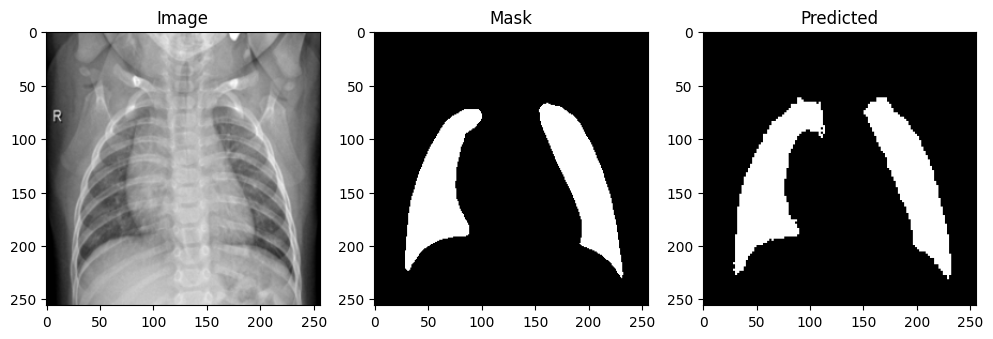

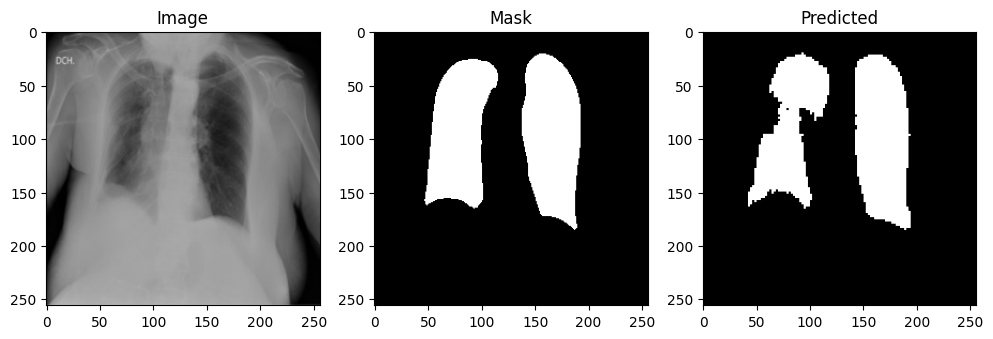

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 601s 244ms/step - classification_accuracy: 0.6114 - classification_loss: 0.9521 - loss: 1.0561 - segmentation_accuracy: 0.9594 - segmentation_binary_io_u: 0.8428 - segmentation_dice_coefficient: 0.8811 - segmentation_loss: 0.1040 - val_classification_accuracy: 0.6619 - val_classification_loss: 0.8070 - val_loss: 0.8763 - val_segmentation_accuracy: 0.9721 - val_segmentation_binary_io_u: 0.8888 - val_segmentation_dice_coefficient: 0.9179 - val_segmentation_loss: 0.0693
Epoch 2/50
2380/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - classification_accuracy: 0.6755 - classification_loss: 0.8133 - loss: 0.8837 - segmentation_accuracy: 0.9718 - segmentation_binary_io_u: 0.8887 - segmentation_dice_coefficient: 0.9156 - segmentation_loss: 0.0704

2025-10-03 22:07:16.949287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - classification_accuracy: 0.6756 - classification_loss: 0.8133 - loss: 0.8836 - segmentation_accuracy: 0.9718 - segmentation_binary_io_u: 0.8887 - segmentation_dice_coefficient: 0.9156 - segmentation_loss: 0.0704

2025-10-03 22:07:19.050571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 22:07:37.984614: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 2: val_classification_accuracy improved from 0.66193 to 0.74195, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


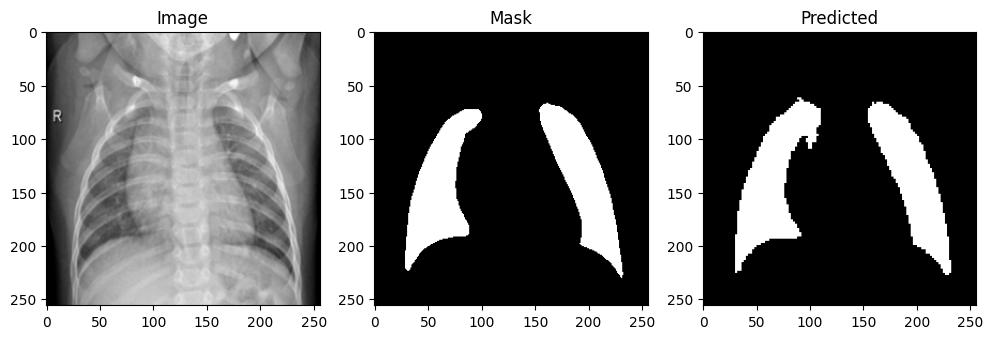

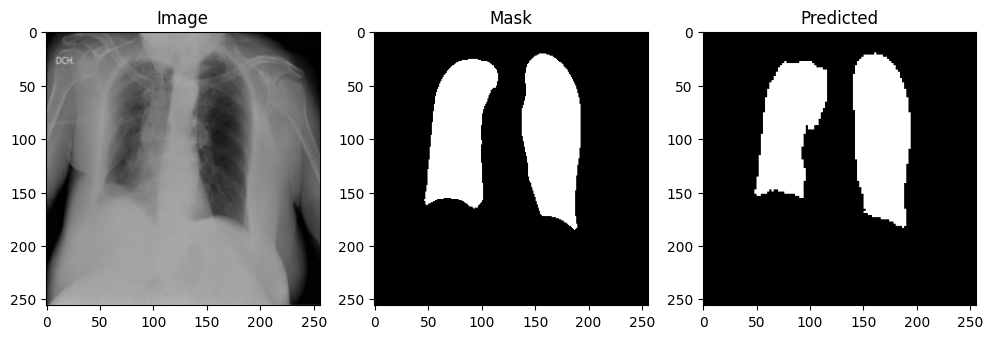

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 580s 244ms/step - classification_accuracy: 0.6907 - classification_loss: 0.7828 - loss: 0.8491 - segmentation_accuracy: 0.9733 - segmentation_binary_io_u: 0.8947 - segmentation_dice_coefficient: 0.9203 - segmentation_loss: 0.0663 - val_classification_accuracy: 0.7420 - val_classification_loss: 0.6167 - val_loss: 0.6705 - val_segmentation_accuracy: 0.9783 - val_segmentation_binary_io_u: 0.9130 - val_segmentation_dice_coefficient: 0.9328 - val_segmentation_loss: 0.0538
Epoch 3/50
2379/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - classification_accuracy: 0.7296 - classification_loss: 0.7010 - loss: 0.7609 - segmentation_accuracy: 0.9759 - segmentation_binary_io_u: 0.9043 - segmentation_dice_coefficient: 0.9277 - segmentation_loss: 0.0599

2025-10-03 22:16:42.656517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - classification_accuracy: 0.7296 - classification_loss: 0.7010 - loss: 0.7609 - segmentation_accuracy: 0.9759 - segmentation_binary_io_u: 0.9043 - segmentation_dice_coefficient: 0.9277 - segmentation_loss: 0.0599

2025-10-03 22:17:03.172770: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 3: val_classification_accuracy did not improve from 0.74195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


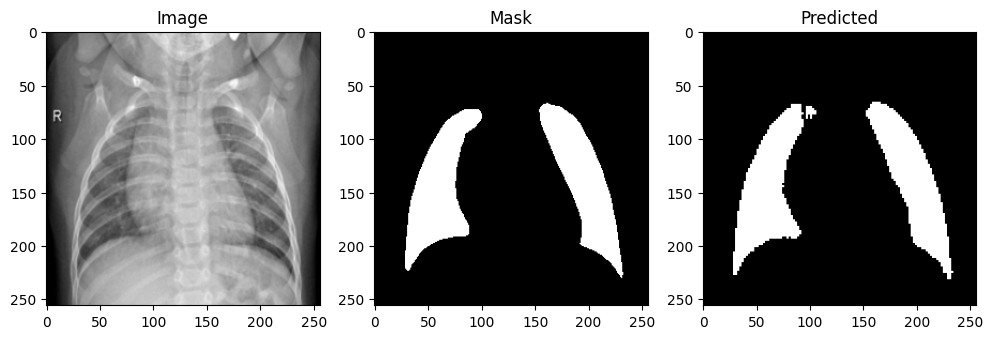

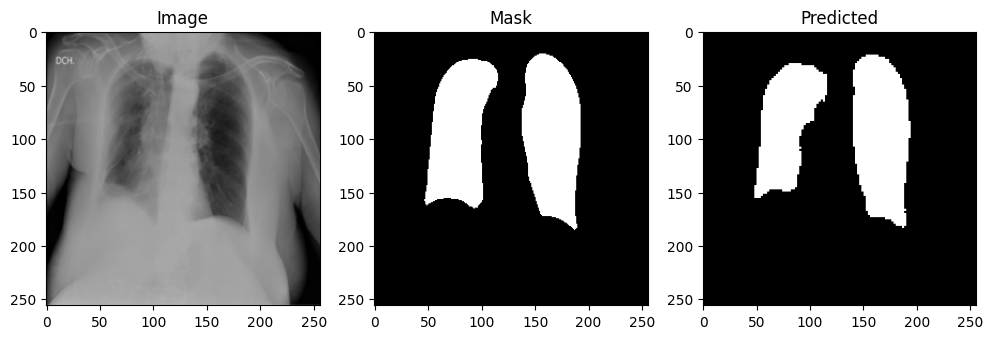

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 563s 236ms/step - classification_accuracy: 0.7397 - classification_loss: 0.6755 - loss: 0.7330 - segmentation_accuracy: 0.9767 - segmentation_binary_io_u: 0.9076 - segmentation_dice_coefficient: 0.9305 - segmentation_loss: 0.0575 - val_classification_accuracy: 0.7386 - val_classification_loss: 0.6692 - val_loss: 0.7190 - val_segmentation_accuracy: 0.9796 - val_segmentation_binary_io_u: 0.9170 - val_segmentation_dice_coefficient: 0.9380 - val_segmentation_loss: 0.0498
Epoch 4/50
2378/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - classification_accuracy: 0.7591 - classification_loss: 0.6213 - loss: 0.6757 - segmentation_accuracy: 0.9779 - segmentation_binary_io_u: 0.9118 - segmentation_dice_coefficient: 0.9337 - segmentation_loss: 0.0544

2025-10-03 22:26:08.212034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - classification_accuracy: 0.7591 - classification_loss: 0.6212 - loss: 0.6757 - segmentation_accuracy: 0.9779 - segmentation_binary_io_u: 0.9118 - segmentation_dice_coefficient: 0.9337 - segmentation_loss: 0.0544

2025-10-03 22:26:10.181647: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: val_classification_accuracy improved from 0.74195 to 0.83381, saving model to best_model.keras


2025-10-03 22:26:28.756826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 22:26:31.146974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


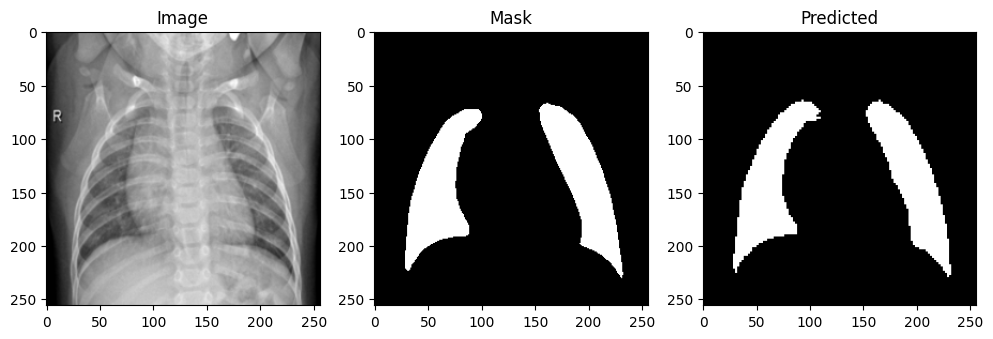

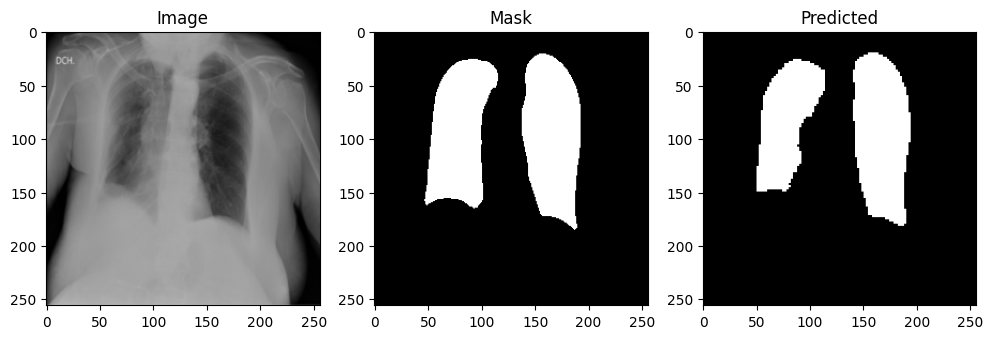

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 566s 238ms/step - classification_accuracy: 0.7695 - classification_loss: 0.6014 - loss: 0.6538 - segmentation_accuracy: 0.9786 - segmentation_binary_io_u: 0.9146 - segmentation_dice_coefficient: 0.9360 - segmentation_loss: 0.0525 - val_classification_accuracy: 0.8338 - val_classification_loss: 0.4555 - val_loss: 0.5015 - val_segmentation_accuracy: 0.9814 - val_segmentation_binary_io_u: 0.9238 - val_segmentation_dice_coefficient: 0.9437 - val_segmentation_loss: 0.0459
Epoch 5/50
2377/2382 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - classification_accuracy: 0.7912 - classification_loss: 0.5621 - loss: 0.6125 - segmentation_accuracy: 0.9794 - segmentation_binary_io_u: 0.9178 - segmentation_dice_coefficient: 0.9384 - segmentation_loss: 0.0504

2025-10-03 22:35:42.112607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - classification_accuracy: 0.7912 - classification_loss: 0.5621 - loss: 0.6125 - segmentation_accuracy: 0.9794 - segmentation_binary_io_u: 0.9178 - segmentation_dice_coefficient: 0.9384 - segmentation_loss: 0.0504

2025-10-03 22:35:44.544089: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 22:36:02.827624: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: val_classification_accuracy did not improve from 0.83381


2025-10-03 22:36:04.170960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


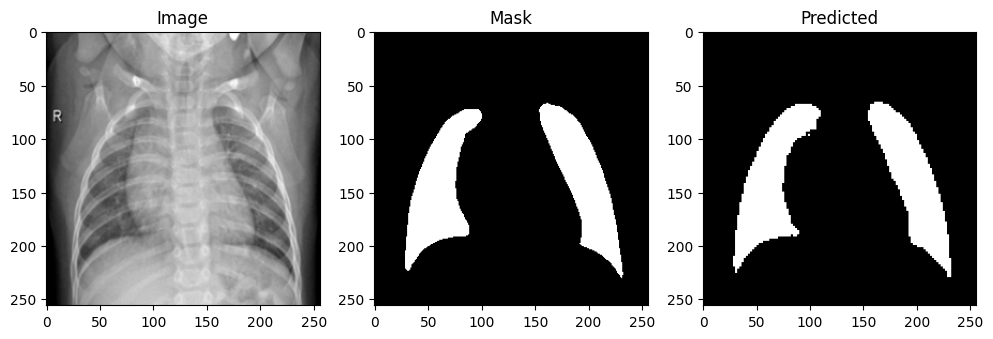

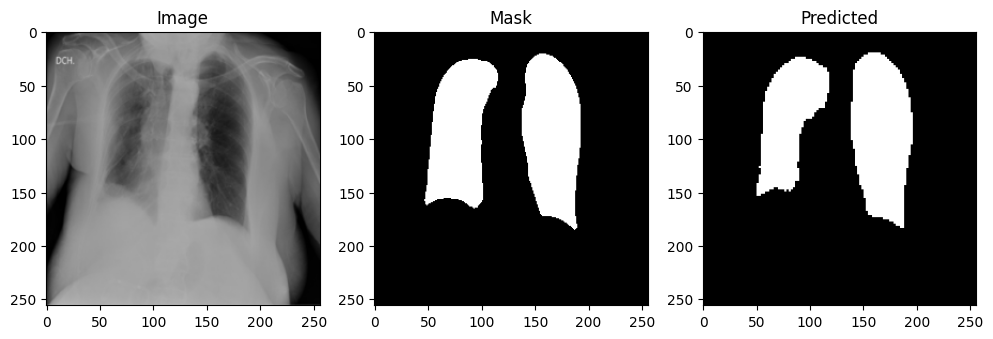

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 573s 241ms/step - classification_accuracy: 0.7987 - classification_loss: 0.5434 - loss: 0.5927 - segmentation_accuracy: 0.9798 - segmentation_binary_io_u: 0.9192 - segmentation_dice_coefficient: 0.9396 - segmentation_loss: 0.0493 - val_classification_accuracy: 0.7874 - val_classification_loss: 0.5388 - val_loss: 0.5834 - val_segmentation_accuracy: 0.9816 - val_segmentation_binary_io_u: 0.9257 - val_segmentation_dice_coefficient: 0.9420 - val_segmentation_loss: 0.0447
Epoch 6/50
2375/2382 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - classification_accuracy: 0.8069 - classification_loss: 0.5229 - loss: 0.5706 - segmentation_accuracy: 0.9804 - segmentation_binary_io_u: 0.9215 - segmentation_dice_coefficient: 0.9414 - segmentation_loss: 0.0477

2025-10-03 22:45:13.982305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - classification_accuracy: 0.8069 - classification_loss: 0.5228 - loss: 0.5705 - segmentation_accuracy: 0.9804 - segmentation_binary_io_u: 0.9215 - segmentation_dice_coefficient: 0.9414 - segmentation_loss: 0.0477

2025-10-03 22:45:35.797842: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 6: val_classification_accuracy did not improve from 0.83381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


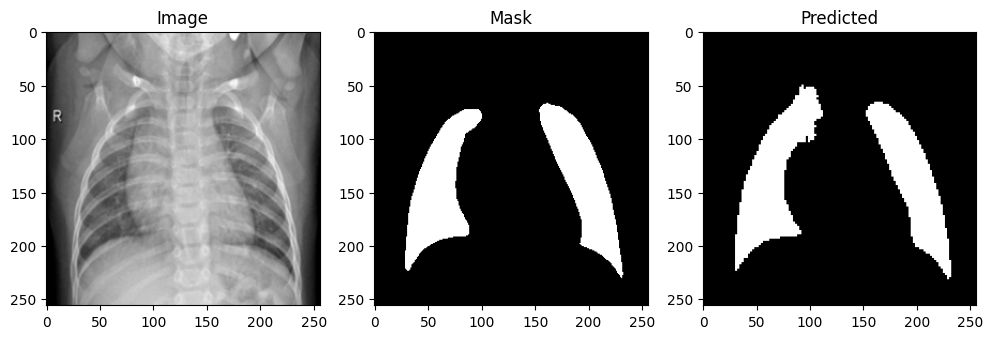

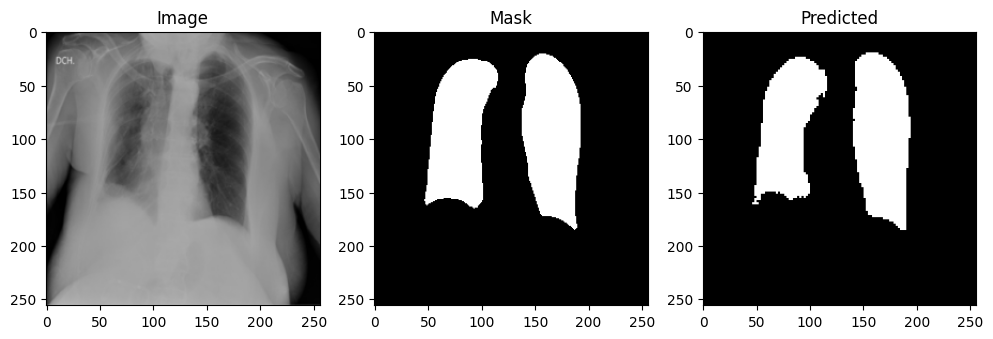

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 573s 240ms/step - classification_accuracy: 0.8113 - classification_loss: 0.5100 - loss: 0.5569 - segmentation_accuracy: 0.9807 - segmentation_binary_io_u: 0.9229 - segmentation_dice_coefficient: 0.9424 - segmentation_loss: 0.0469 - val_classification_accuracy: 0.8191 - val_classification_loss: 0.4702 - val_loss: 0.5118 - val_segmentation_accuracy: 0.9831 - val_segmentation_binary_io_u: 0.9313 - val_segmentation_dice_coefficient: 0.9441 - val_segmentation_loss: 0.0415
Epoch 7/50
2374/2382 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - classification_accuracy: 0.8184 - classification_loss: 0.4886 - loss: 0.5348 - segmentation_accuracy: 0.9810 - segmentation_binary_io_u: 0.9237 - segmentation_dice_coefficient: 0.9429 - segmentation_loss: 0.0462

2025-10-03 22:54:33.560192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - classification_accuracy: 0.8184 - classification_loss: 0.4886 - loss: 0.5348 - segmentation_accuracy: 0.9810 - segmentation_binary_io_u: 0.9237 - segmentation_dice_coefficient: 0.9429 - segmentation_loss: 0.0462

2025-10-03 22:54:35.803987: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 22:54:55.352177: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 7: val_classification_accuracy did not improve from 0.83381


2025-10-03 22:54:56.467751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 22:54:56.667806: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


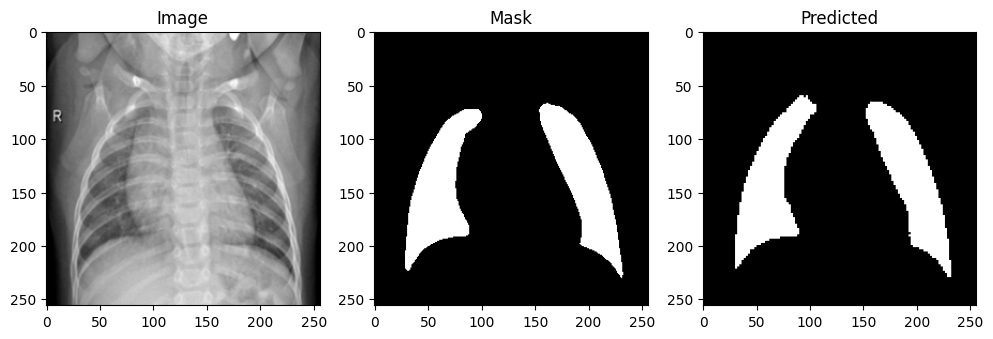

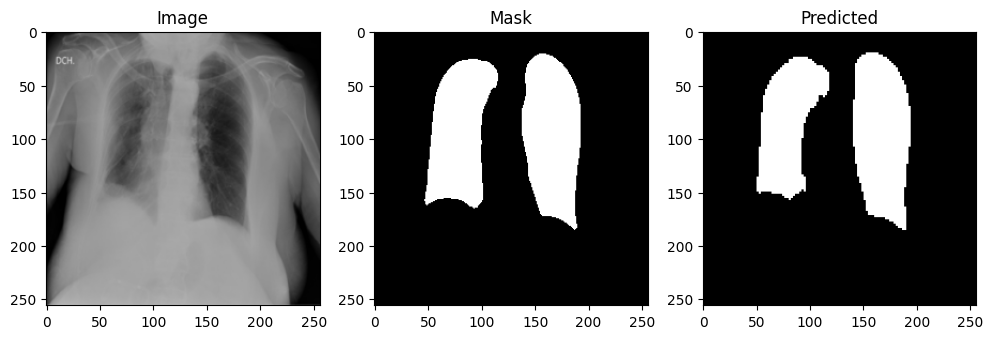

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 559s 235ms/step - classification_accuracy: 0.8241 - classification_loss: 0.4767 - loss: 0.5219 - segmentation_accuracy: 0.9813 - segmentation_binary_io_u: 0.9252 - segmentation_dice_coefficient: 0.9442 - segmentation_loss: 0.0452 - val_classification_accuracy: 0.8267 - val_classification_loss: 0.4471 - val_loss: 0.4862 - val_segmentation_accuracy: 0.9839 - val_segmentation_binary_io_u: 0.9346 - val_segmentation_dice_coefficient: 0.9482 - val_segmentation_loss: 0.0391
Epoch 8/50
2374/2382 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - classification_accuracy: 0.8295 - classification_loss: 0.4702 - loss: 0.5154 - segmentation_accuracy: 0.9814 - segmentation_binary_io_u: 0.9255 - segmentation_dice_coefficient: 0.9444 - segmentation_loss: 0.0451

2025-10-03 23:03:54.521189: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - classification_accuracy: 0.8295 - classification_loss: 0.4702 - loss: 0.5153 - segmentation_accuracy: 0.9814 - segmentation_binary_io_u: 0.9255 - segmentation_dice_coefficient: 0.9444 - segmentation_loss: 0.0451

2025-10-03 23:03:57.949443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 23:04:16.437110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 8: val_classification_accuracy did not improve from 0.83381


2025-10-03 23:04:18.799436: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


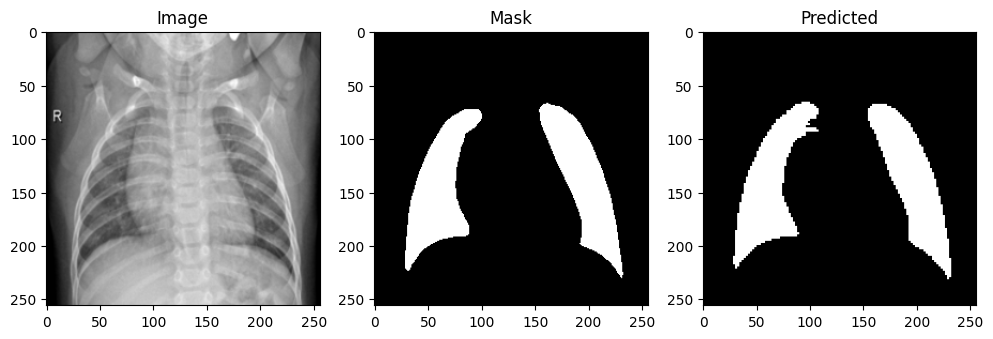

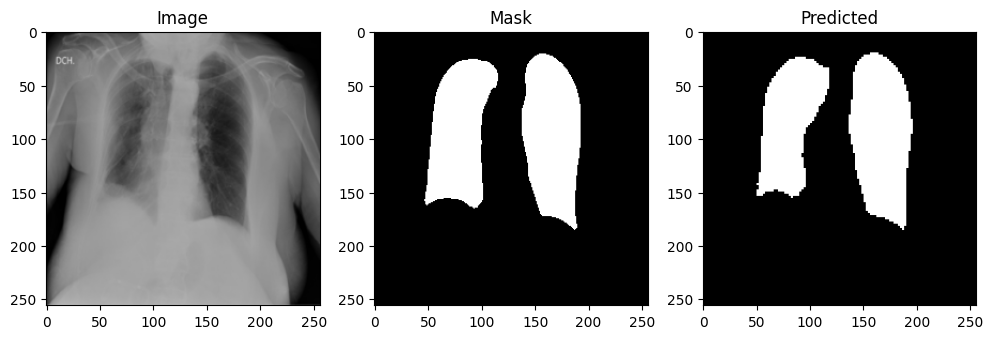

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 563s 236ms/step - classification_accuracy: 0.8299 - classification_loss: 0.4614 - loss: 0.5054 - segmentation_accuracy: 0.9818 - segmentation_binary_io_u: 0.9271 - segmentation_dice_coefficient: 0.9456 - segmentation_loss: 0.0440 - val_classification_accuracy: 0.8026 - val_classification_loss: 0.5209 - val_loss: 0.5630 - val_segmentation_accuracy: 0.9825 - val_segmentation_binary_io_u: 0.9291 - val_segmentation_dice_coefficient: 0.9459 - val_segmentation_loss: 0.0421
Epoch 9/50
2373/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - classification_accuracy: 0.8354 - classification_loss: 0.4526 - loss: 0.4959 - segmentation_accuracy: 0.9821 - segmentation_binary_io_u: 0.9280 - segmentation_dice_coefficient: 0.9464 - segmentation_loss: 0.0433

2025-10-03 23:13:25.568784: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - classification_accuracy: 0.8354 - classification_loss: 0.4525 - loss: 0.4958 - segmentation_accuracy: 0.9821 - segmentation_binary_io_u: 0.9280 - segmentation_dice_coefficient: 0.9464 - segmentation_loss: 0.0433

2025-10-03 23:13:28.986897: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 23:13:48.744772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 9: val_classification_accuracy improved from 0.83381 to 0.84422, saving model to best_model.keras


2025-10-03 23:13:51.795721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


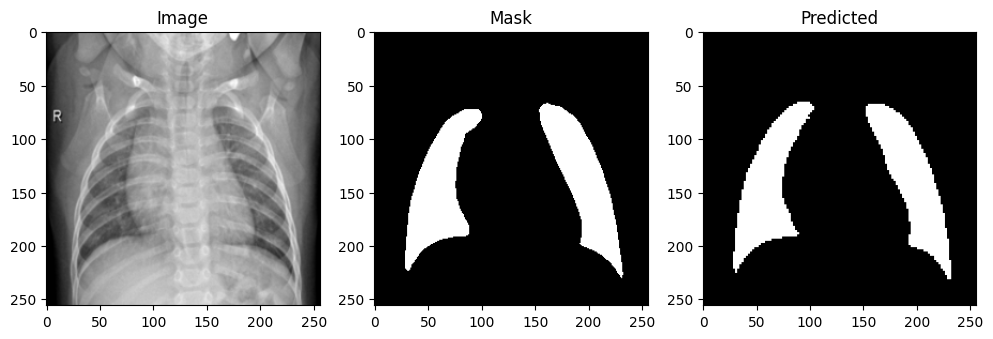

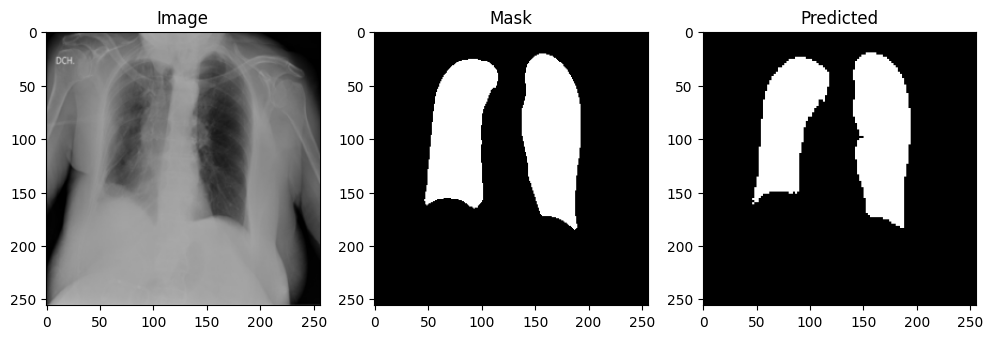

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 573s 240ms/step - classification_accuracy: 0.8363 - classification_loss: 0.4454 - loss: 0.4882 - segmentation_accuracy: 0.9823 - segmentation_binary_io_u: 0.9289 - segmentation_dice_coefficient: 0.9471 - segmentation_loss: 0.0427 - val_classification_accuracy: 0.8442 - val_classification_loss: 0.4007 - val_loss: 0.4382 - val_segmentation_accuracy: 0.9844 - val_segmentation_binary_io_u: 0.9365 - val_segmentation_dice_coefficient: 0.9509 - val_segmentation_loss: 0.0375
Epoch 10/50
2371/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - classification_accuracy: 0.8431 - classification_loss: 0.4257 - loss: 0.4680 - segmentation_accuracy: 0.9824 - segmentation_binary_io_u: 0.9296 - segmentation_dice_coefficient: 0.9476 - segmentation_loss: 0.0423

2025-10-03 23:22:54.024791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - classification_accuracy: 0.8431 - classification_loss: 0.4257 - loss: 0.4680 - segmentation_accuracy: 0.9824 - segmentation_binary_io_u: 0.9296 - segmentation_dice_coefficient: 0.9476 - segmentation_loss: 0.0423

2025-10-03 23:22:57.402974: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 23:23:15.494074: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: val_classification_accuracy improved from 0.84422 to 0.85559, saving model to best_model.keras


2025-10-03 23:23:17.744206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


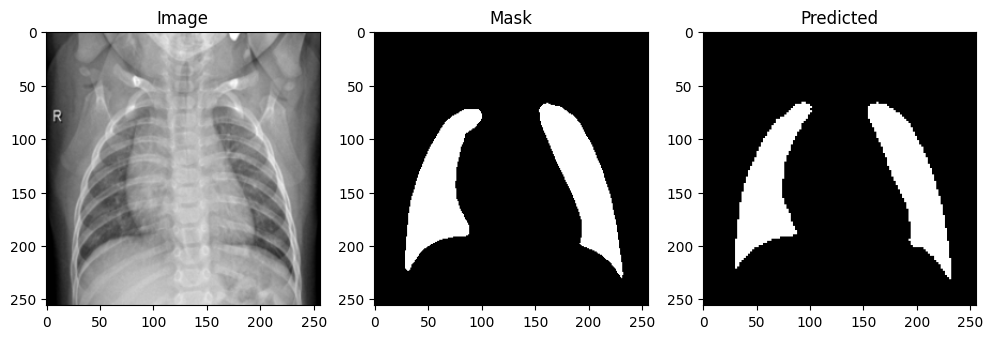

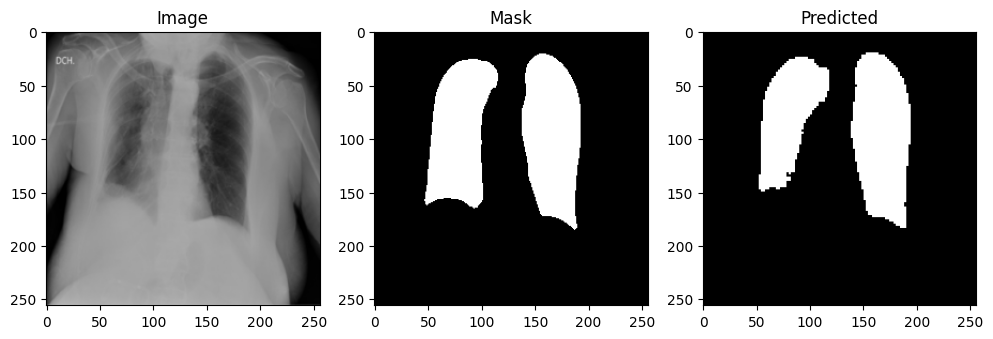

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 566s 237ms/step - classification_accuracy: 0.8441 - classification_loss: 0.4244 - loss: 0.4664 - segmentation_accuracy: 0.9825 - segmentation_binary_io_u: 0.9300 - segmentation_dice_coefficient: 0.9480 - segmentation_loss: 0.0420 - val_classification_accuracy: 0.8556 - val_classification_loss: 0.3816 - val_loss: 0.4168 - val_segmentation_accuracy: 0.9854 - val_segmentation_binary_io_u: 0.9400 - val_segmentation_dice_coefficient: 0.9531 - val_segmentation_loss: 0.0352
Epoch 11/50
2371/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - classification_accuracy: 0.8534 - classification_loss: 0.4085 - loss: 0.4499 - segmentation_accuracy: 0.9828 - segmentation_binary_io_u: 0.9309 - segmentation_dice_coefficient: 0.9485 - segmentation_loss: 0.0413

2025-10-03 23:32:15.847860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - classification_accuracy: 0.8534 - classification_loss: 0.4086 - loss: 0.4499 - segmentation_accuracy: 0.9828 - segmentation_binary_io_u: 0.9309 - segmentation_dice_coefficient: 0.9485 - segmentation_loss: 0.0413

2025-10-03 23:32:38.879116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 11: val_classification_accuracy did not improve from 0.85559


2025-10-03 23:32:39.992681: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


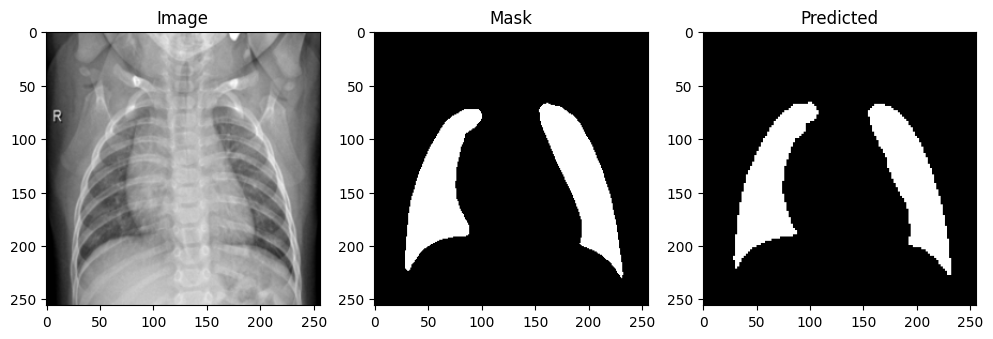

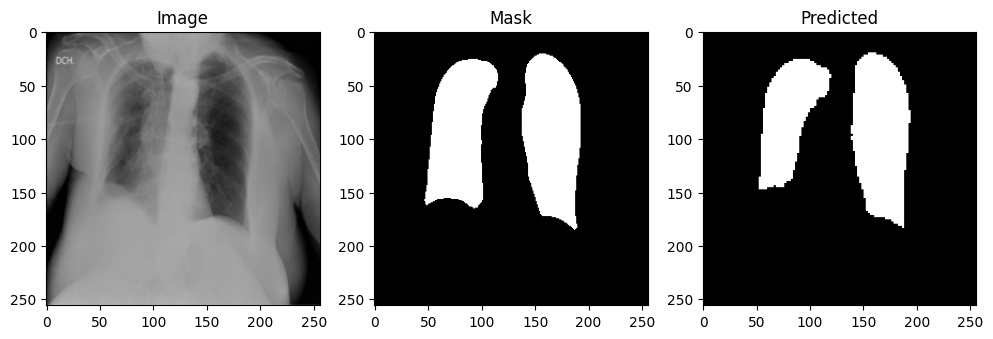

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 562s 236ms/step - classification_accuracy: 0.8523 - classification_loss: 0.4110 - loss: 0.4520 - segmentation_accuracy: 0.9829 - segmentation_binary_io_u: 0.9314 - segmentation_dice_coefficient: 0.9491 - segmentation_loss: 0.0410 - val_classification_accuracy: 0.8404 - val_classification_loss: 0.4152 - val_loss: 0.4524 - val_segmentation_accuracy: 0.9844 - val_segmentation_binary_io_u: 0.9358 - val_segmentation_dice_coefficient: 0.9515 - val_segmentation_loss: 0.0373
Epoch 12/50
2370/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - classification_accuracy: 0.8559 - classification_loss: 0.3970 - loss: 0.4378 - segmentation_accuracy: 0.9830 - segmentation_binary_io_u: 0.9319 - segmentation_dice_coefficient: 0.9494 - segmentation_loss: 0.0407

2025-10-03 23:41:36.776068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - classification_accuracy: 0.8559 - classification_loss: 0.3970 - loss: 0.4378 - segmentation_accuracy: 0.9830 - segmentation_binary_io_u: 0.9319 - segmentation_dice_coefficient: 0.9494 - segmentation_loss: 0.0407

2025-10-03 23:41:40.611140: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-03 23:41:59.666465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 12: val_classification_accuracy improved from 0.85559 to 0.85938, saving model to best_model.keras


2025-10-03 23:42:01.825658: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


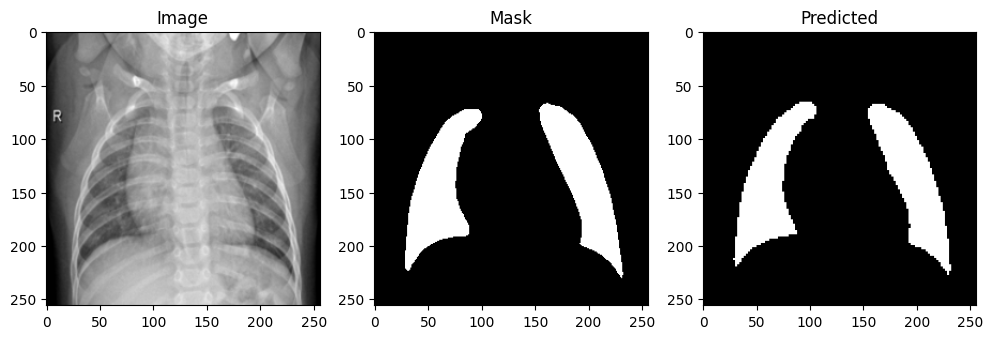

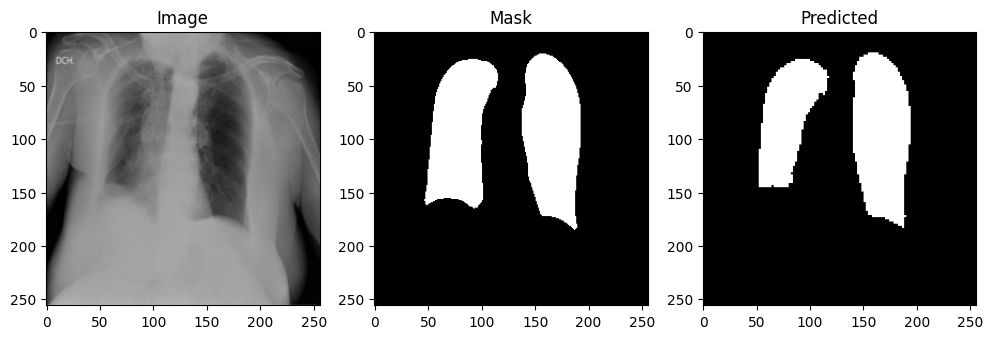

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 568s 238ms/step - classification_accuracy: 0.8547 - classification_loss: 0.3985 - loss: 0.4389 - segmentation_accuracy: 0.9831 - segmentation_binary_io_u: 0.9324 - segmentation_dice_coefficient: 0.9498 - segmentation_loss: 0.0405 - val_classification_accuracy: 0.8594 - val_classification_loss: 0.3601 - val_loss: 0.3967 - val_segmentation_accuracy: 0.9849 - val_segmentation_binary_io_u: 0.9380 - val_segmentation_dice_coefficient: 0.9507 - val_segmentation_loss: 0.0365
Epoch 13/50
2369/2382 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - classification_accuracy: 0.8588 - classification_loss: 0.3855 - loss: 0.4256 - segmentation_accuracy: 0.9833 - segmentation_binary_io_u: 0.9329 - segmentation_dice_coefficient: 0.9501 - segmentation_loss: 0.0402

2025-10-03 23:51:33.441343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - classification_accuracy: 0.8588 - classification_loss: 0.3855 - loss: 0.4256 - segmentation_accuracy: 0.9833 - segmentation_binary_io_u: 0.9329 - segmentation_dice_coefficient: 0.9502 - segmentation_loss: 0.0402

2025-10-03 23:51:56.611561: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 13: val_classification_accuracy did not improve from 0.85938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


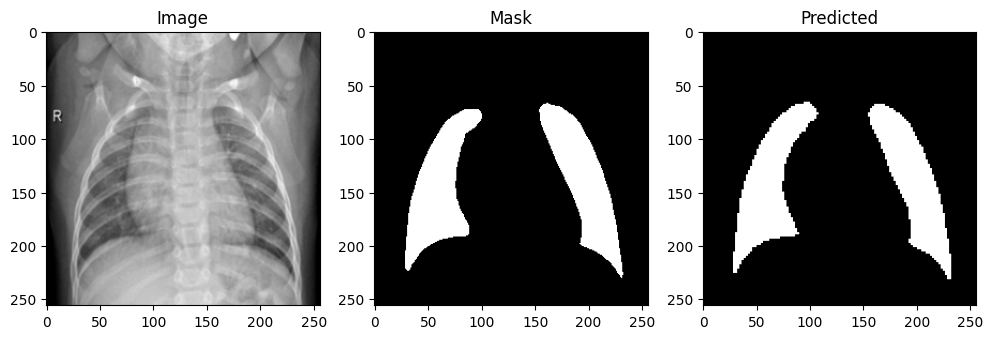

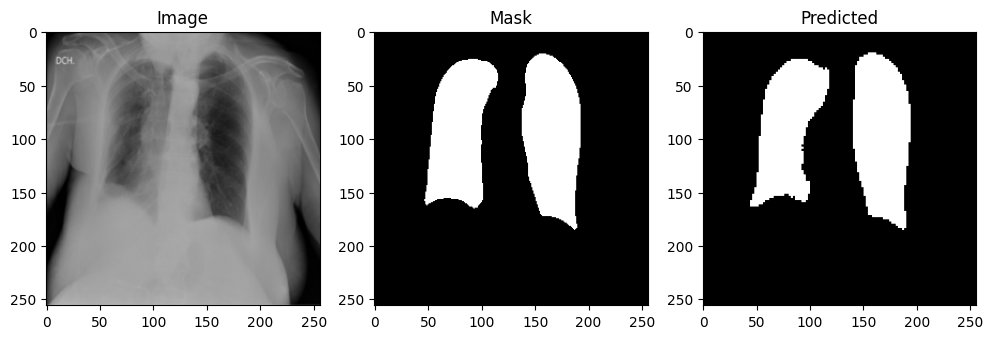

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 591s 248ms/step - classification_accuracy: 0.8597 - classification_loss: 0.3843 - loss: 0.4239 - segmentation_accuracy: 0.9834 - segmentation_binary_io_u: 0.9335 - segmentation_dice_coefficient: 0.9506 - segmentation_loss: 0.0397 - val_classification_accuracy: 0.8466 - val_classification_loss: 0.4092 - val_loss: 0.4421 - val_segmentation_accuracy: 0.9862 - val_segmentation_binary_io_u: 0.9433 - val_segmentation_dice_coefficient: 0.9574 - val_segmentation_loss: 0.0329
Epoch 14/50
2368/2382 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - classification_accuracy: 0.8604 - classification_loss: 0.3832 - loss: 0.4227 - segmentation_accuracy: 0.9834 - segmentation_binary_io_u: 0.9334 - segmentation_dice_coefficient: 0.9506 - segmentation_loss: 0.0395

2025-10-04 00:01:00.736598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - classification_accuracy: 0.8604 - classification_loss: 0.3832 - loss: 0.4227 - segmentation_accuracy: 0.9834 - segmentation_binary_io_u: 0.9334 - segmentation_dice_coefficient: 0.9506 - segmentation_loss: 0.0395

2025-10-04 00:01:22.819193: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_classification_accuracy did not improve from 0.85938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


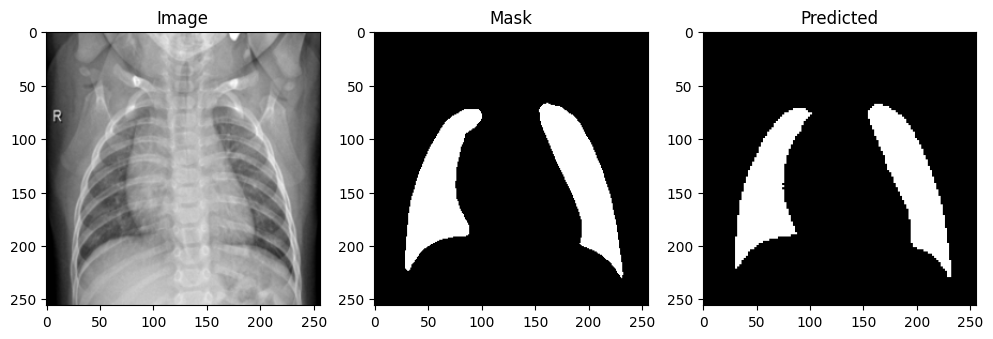

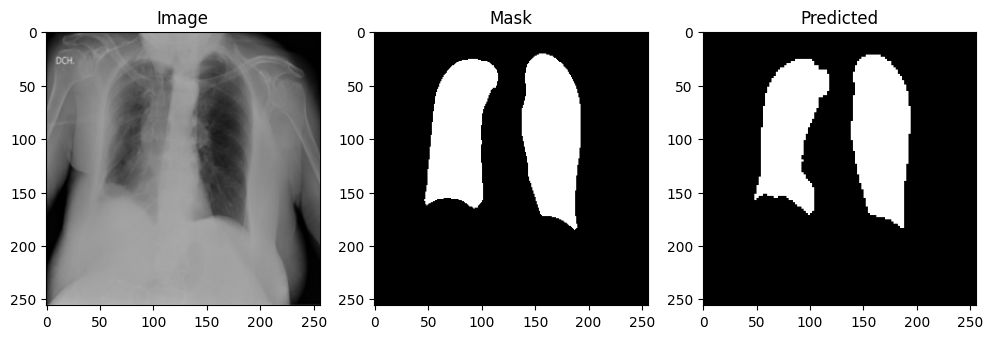

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 565s 237ms/step - classification_accuracy: 0.8622 - classification_loss: 0.3803 - loss: 0.4196 - segmentation_accuracy: 0.9835 - segmentation_binary_io_u: 0.9338 - segmentation_dice_coefficient: 0.9509 - segmentation_loss: 0.0393 - val_classification_accuracy: 0.8362 - val_classification_loss: 0.4142 - val_loss: 0.4508 - val_segmentation_accuracy: 0.9848 - val_segmentation_binary_io_u: 0.9373 - val_segmentation_dice_coefficient: 0.9526 - val_segmentation_loss: 0.0366
Epoch 15/50
2367/2382 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - classification_accuracy: 0.8693 - classification_loss: 0.3636 - loss: 0.4024 - segmentation_accuracy: 0.9838 - segmentation_binary_io_u: 0.9346 - segmentation_dice_coefficient: 0.9515 - segmentation_loss: 0.0387

2025-10-04 00:10:25.699322: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - classification_accuracy: 0.8693 - classification_loss: 0.3636 - loss: 0.4024 - segmentation_accuracy: 0.9838 - segmentation_binary_io_u: 0.9346 - segmentation_dice_coefficient: 0.9515 - segmentation_loss: 0.0387

2025-10-04 00:10:30.303742: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-04 00:10:49.120107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 15: val_classification_accuracy improved from 0.85938 to 0.88873, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


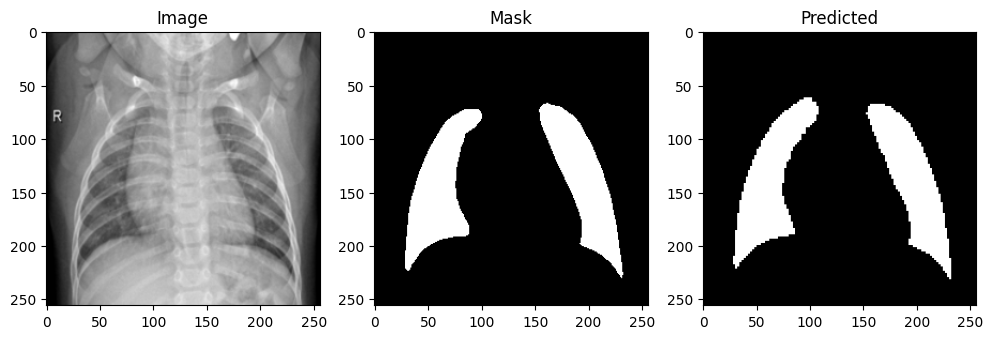

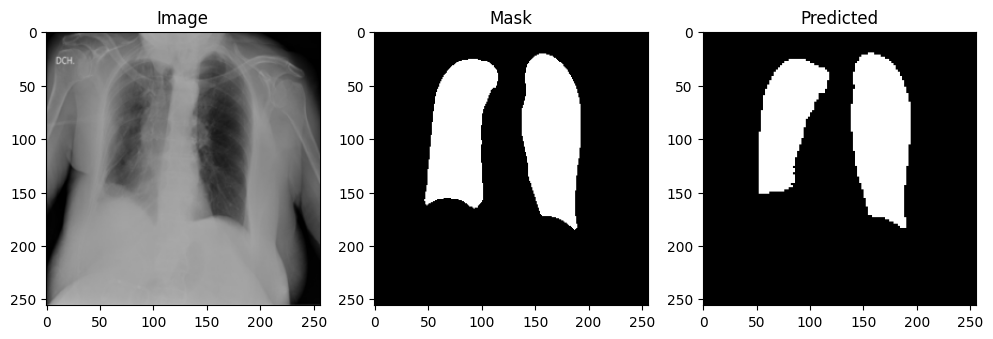

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 568s 239ms/step - classification_accuracy: 0.8672 - classification_loss: 0.3664 - loss: 0.4050 - segmentation_accuracy: 0.9838 - segmentation_binary_io_u: 0.9349 - segmentation_dice_coefficient: 0.9517 - segmentation_loss: 0.0386 - val_classification_accuracy: 0.8887 - val_classification_loss: 0.3084 - val_loss: 0.3407 - val_segmentation_accuracy: 0.9864 - val_segmentation_binary_io_u: 0.9445 - val_segmentation_dice_coefficient: 0.9567 - val_segmentation_loss: 0.0323
Epoch 16/50
2365/2382 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - classification_accuracy: 0.8759 - classification_loss: 0.3532 - loss: 0.3919 - segmentation_accuracy: 0.9838 - segmentation_binary_io_u: 0.9348 - segmentation_dice_coefficient: 0.9517 - segmentation_loss: 0.0387

2025-10-04 00:19:50.663543: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - classification_accuracy: 0.8759 - classification_loss: 0.3532 - loss: 0.3919 - segmentation_accuracy: 0.9838 - segmentation_binary_io_u: 0.9348 - segmentation_dice_coefficient: 0.9517 - segmentation_loss: 0.0387

2025-10-04 00:19:55.821872: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-04 00:20:13.964743: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 16: val_classification_accuracy did not improve from 0.88873


2025-10-04 00:20:14.971253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


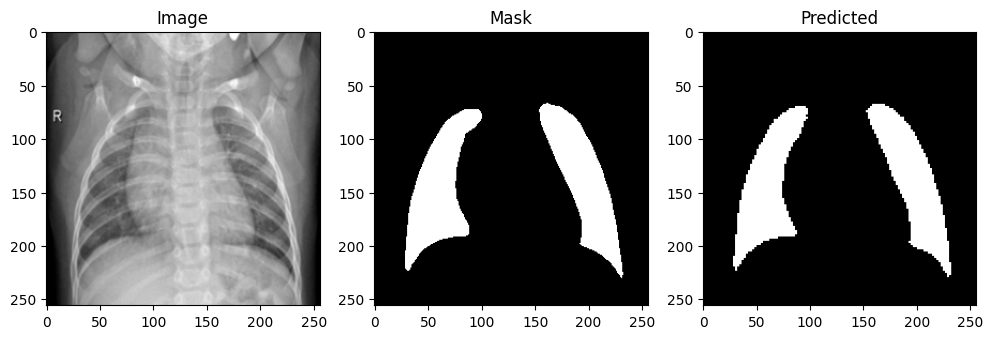

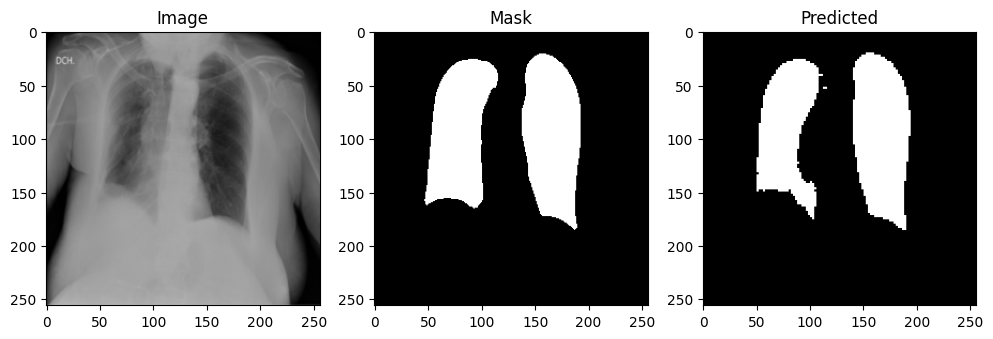

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 563s 236ms/step - classification_accuracy: 0.8746 - classification_loss: 0.3562 - loss: 0.3945 - segmentation_accuracy: 0.9840 - segmentation_binary_io_u: 0.9355 - segmentation_dice_coefficient: 0.9522 - segmentation_loss: 0.0382 - val_classification_accuracy: 0.8523 - val_classification_loss: 0.3833 - val_loss: 0.4239 - val_segmentation_accuracy: 0.9833 - val_segmentation_binary_io_u: 0.9311 - val_segmentation_dice_coefficient: 0.9496 - val_segmentation_loss: 0.0406
Epoch 17/50
2364/2382 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - classification_accuracy: 0.8782 - classification_loss: 0.3473 - loss: 0.3855 - segmentation_accuracy: 0.9839 - segmentation_binary_io_u: 0.9352 - segmentation_dice_coefficient: 0.9521 - segmentation_loss: 0.0383

2025-10-04 00:29:35.164367: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - classification_accuracy: 0.8782 - classification_loss: 0.3473 - loss: 0.3855 - segmentation_accuracy: 0.9839 - segmentation_binary_io_u: 0.9352 - segmentation_dice_coefficient: 0.9521 - segmentation_loss: 0.0383

2025-10-04 00:29:59.583936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 17: val_classification_accuracy did not improve from 0.88873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


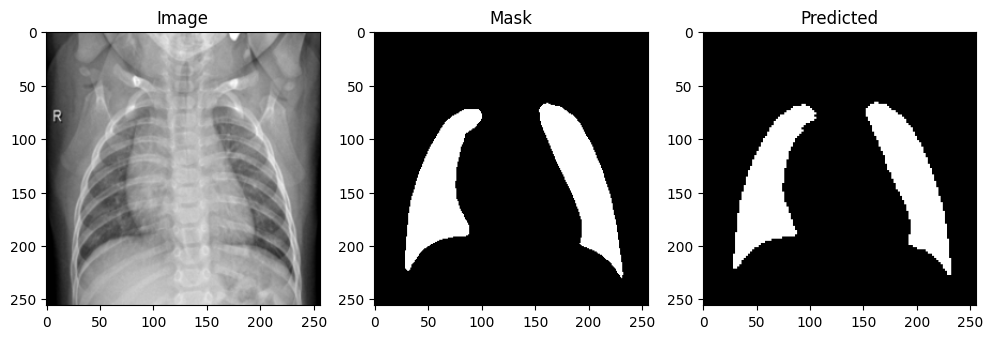

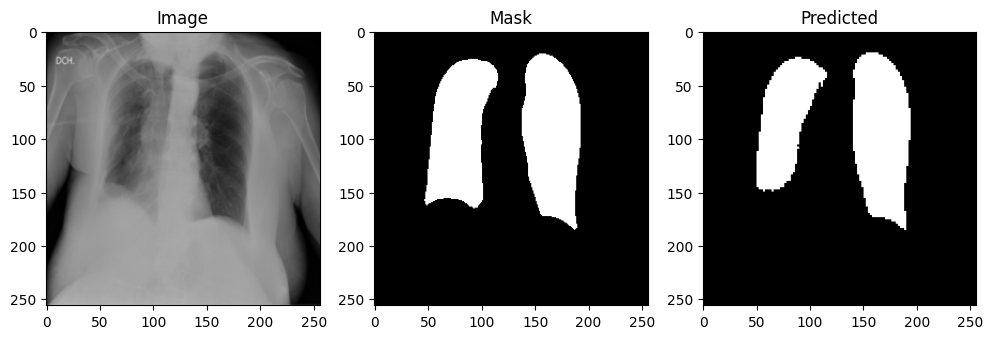

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 586s 246ms/step - classification_accuracy: 0.8759 - classification_loss: 0.3470 - loss: 0.3847 - segmentation_accuracy: 0.9842 - segmentation_binary_io_u: 0.9363 - segmentation_dice_coefficient: 0.9529 - segmentation_loss: 0.0376 - val_classification_accuracy: 0.8722 - val_classification_loss: 0.3468 - val_loss: 0.3793 - val_segmentation_accuracy: 0.9864 - val_segmentation_binary_io_u: 0.9442 - val_segmentation_dice_coefficient: 0.9569 - val_segmentation_loss: 0.0325
Epoch 18/50
2363/2382 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - classification_accuracy: 0.8757 - classification_loss: 0.3517 - loss: 0.3894 - segmentation_accuracy: 0.9842 - segmentation_binary_io_u: 0.9363 - segmentation_dice_coefficient: 0.9529 - segmentation_loss: 0.0376

2025-10-04 00:39:08.586152: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - classification_accuracy: 0.8757 - classification_loss: 0.3517 - loss: 0.3893 - segmentation_accuracy: 0.9842 - segmentation_binary_io_u: 0.9363 - segmentation_dice_coefficient: 0.9529 - segmentation_loss: 0.0376

2025-10-04 00:39:13.930044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-04 00:39:32.047144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_classification_accuracy did not improve from 0.88873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


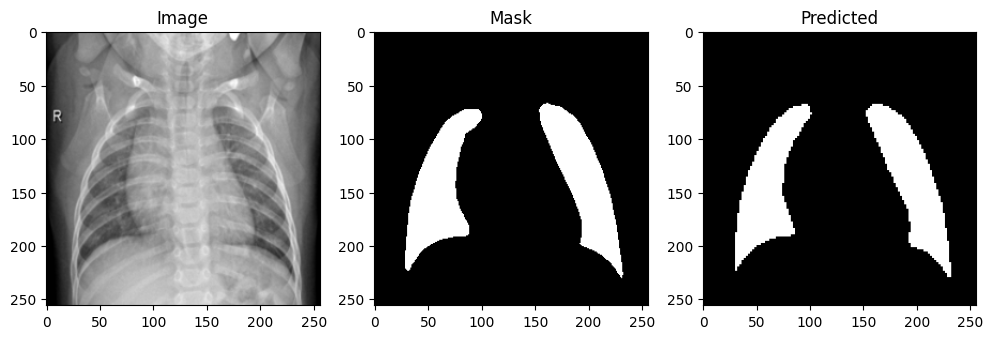

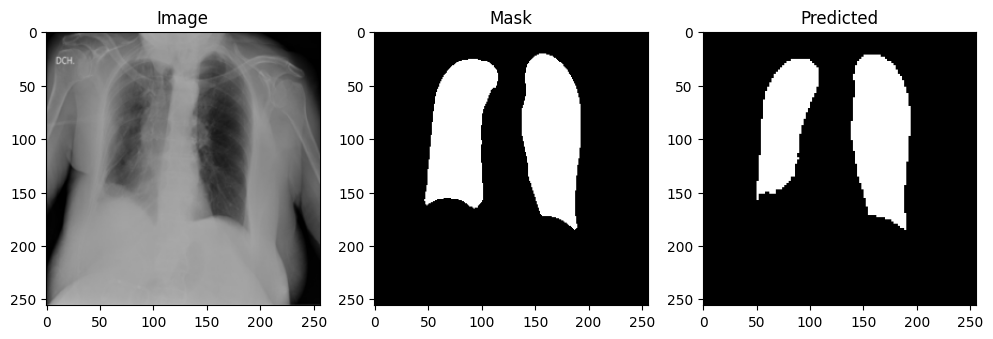

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 572s 240ms/step - classification_accuracy: 0.8740 - classification_loss: 0.3484 - loss: 0.3858 - segmentation_accuracy: 0.9843 - segmentation_binary_io_u: 0.9367 - segmentation_dice_coefficient: 0.9533 - segmentation_loss: 0.0373 - val_classification_accuracy: 0.8821 - val_classification_loss: 0.3127 - val_loss: 0.3446 - val_segmentation_accuracy: 0.9866 - val_segmentation_binary_io_u: 0.9451 - val_segmentation_dice_coefficient: 0.9589 - val_segmentation_loss: 0.0319
Epoch 19/50
2362/2382 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - classification_accuracy: 0.8768 - classification_loss: 0.3388 - loss: 0.3758 - segmentation_accuracy: 0.9844 - segmentation_binary_io_u: 0.9371 - segmentation_dice_coefficient: 0.9535 - segmentation_loss: 0.0370

2025-10-04 00:50:43.620677: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - classification_accuracy: 0.8768 - classification_loss: 0.3388 - loss: 0.3758 - segmentation_accuracy: 0.9844 - segmentation_binary_io_u: 0.9371 - segmentation_dice_coefficient: 0.9535 - segmentation_loss: 0.0370

2025-10-04 00:50:49.607886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-04 00:51:08.916231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 19: val_classification_accuracy did not improve from 0.88873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


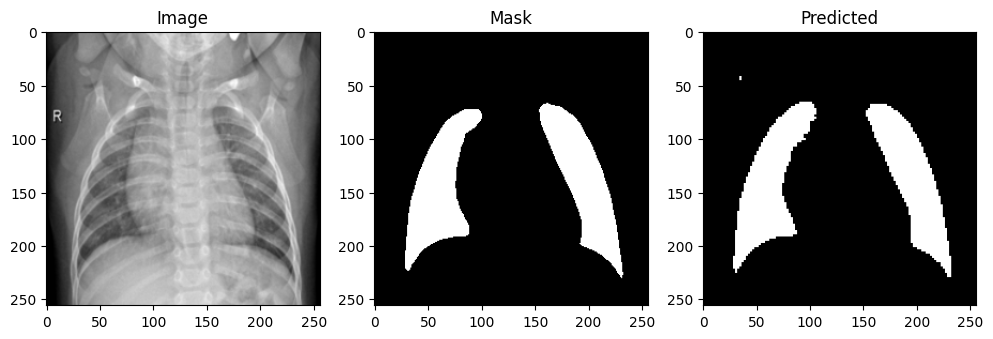

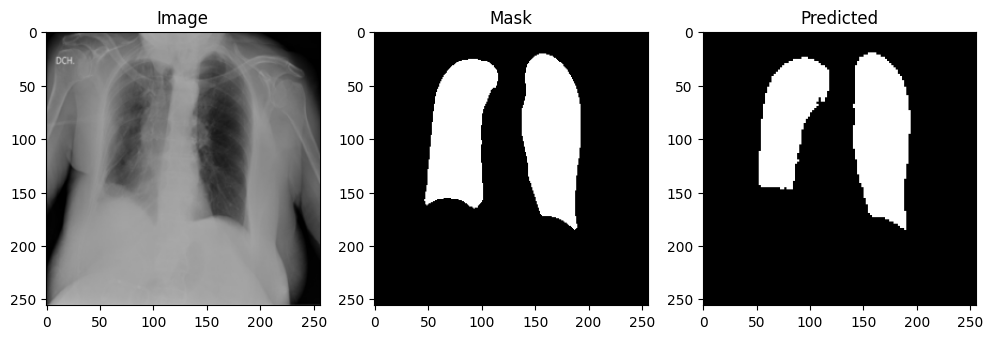

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 697s 292ms/step - classification_accuracy: 0.8757 - classification_loss: 0.3417 - loss: 0.3788 - segmentation_accuracy: 0.9844 - segmentation_binary_io_u: 0.9371 - segmentation_dice_coefficient: 0.9535 - segmentation_loss: 0.0371 - val_classification_accuracy: 0.8130 - val_classification_loss: 0.4774 - val_loss: 0.5104 - val_segmentation_accuracy: 0.9862 - val_segmentation_binary_io_u: 0.9434 - val_segmentation_dice_coefficient: 0.9572 - val_segmentation_loss: 0.0329
Epoch 20/50
2362/2382 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - classification_accuracy: 0.8827 - classification_loss: 0.3292 - loss: 0.3665 - segmentation_accuracy: 0.9843 - segmentation_binary_io_u: 0.9368 - segmentation_dice_coefficient: 0.9533 - segmentation_loss: 0.0372

2025-10-04 01:00:16.673934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388736 bytes after encountering the first element of size 8388736 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2382/2382 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - classification_accuracy: 0.8827 - classification_loss: 0.3292 - loss: 0.3665 - segmentation_accuracy: 0.9843 - segmentation_binary_io_u: 0.9368 - segmentation_dice_coefficient: 0.9533 - segmentation_loss: 0.0372

2025-10-04 01:00:39.944978: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 10486016 bytes after encountering the first element of size 10486016 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 20: val_classification_accuracy did not improve from 0.88873

Epoch 20: Early stopping (classification did not improve).


2025-10-04 01:00:41.032794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


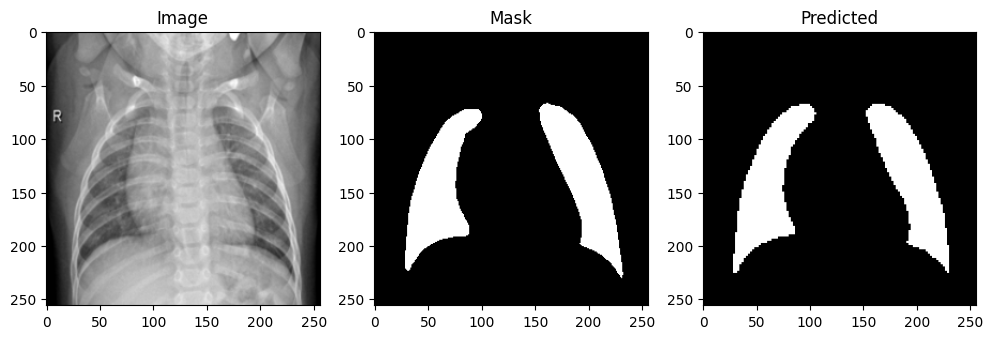

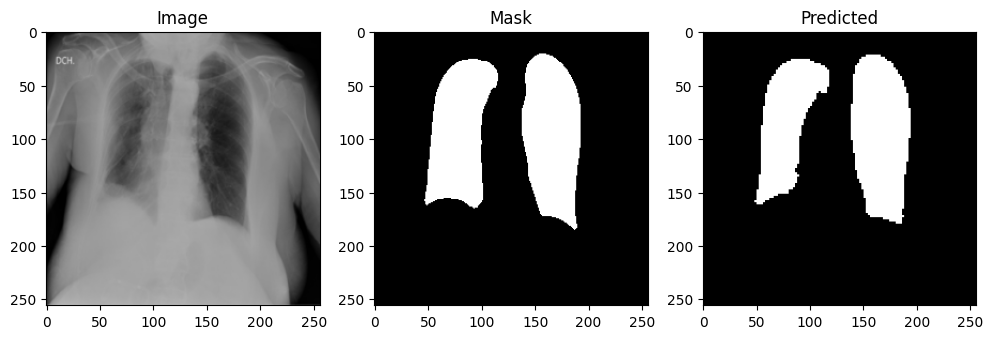

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 571s 240ms/step - classification_accuracy: 0.8806 - classification_loss: 0.3320 - loss: 0.3688 - segmentation_accuracy: 0.9845 - segmentation_binary_io_u: 0.9374 - segmentation_dice_coefficient: 0.9537 - segmentation_loss: 0.0369 - val_classification_accuracy: 0.8253 - val_classification_loss: 0.4620 - val_loss: 0.4978 - val_segmentation_accuracy: 0.9852 - val_segmentation_binary_io_u: 0.9393 - val_segmentation_dice_coefficient: 0.9535 - val_segmentation_loss: 0.0358


In [58]:
NUM_EPOCHS = 50
history = model.fit(
    train_dataset.repeat(),
    epochs= NUM_EPOCHS,
    validation_data= val_dataset.repeat(),
    steps_per_epoch= steps_per_epoch,
    validation_steps= validation_steps,
    callbacks= callbacks
)

---
### 6.2 Performance Analysis and Final Project Conclusion on Validation Data

The training execution, managed by the custom `MultiTaskCallback`, successfully converged. We analyze the final state of the model based on the last recorded epochs and visualization outputs from the validation data.

#### Key Validation Metrics (Best Performance):

| Metric | Best Validation Score | Assessment |
| :--- | :--- | :--- |
| **Segmentation Dice Coefficient** | **~0.957** | **Excellent.** Indicates near-perfect, highly accurate pixel-level localization of the lung boundaries. |
| **Classification Accuracy (4-Class Prototype)** | **~0.889 - 0.893** | **Good.** Shows the network learned discriminative features, but its performance is considered a benchmark, not a final solution. |

#### Final Conclusion and Project Strategy

1.  **Segmentation Head Success (RETAINED):**
    * The segmentation head is a definitive success. The high Dice Coefficient and clear visual outputs from the `SegmentationVisualization` callback  confirm the U-Net accurately identifies the lung area. This segmentation functionality **will be retained** as the first, crucial step in the project's final pipeline for pre-processing X-ray images.

2.  **Classification Head Status (DISCARDED):**
    * While the 4-class classification achieved a nearly 90% accuracy, this score is still considered **noisy** and prone to error compared to results achievable by dedicated, high-performance architectures (like MobileNet, EfficientNet, or Inception).
    * **Project Decision:** The classification head developed in this multi-task prototype **will be ignored and discarded** in subsequent project steps. The final project will pivot to developing a specialized, high-accuracy binary classifier (Healthy vs. Unhealthy lung prediction) using dedicated classification models, separate from this U-Net architecture.

3.  **Callback Validation:**
    * The custom `MultiTaskCallback` successfully governed the training, managing the dual objectives and likely stopping the training automatically based on the stabilization of one or both metrics (e.g., around Epoch 16, where classification plateaued).

In summary, this notebook served its purpose by delivering a production-ready **Segmentation Model** (the U-Net) and validating the concept of multi-task control, while confirming the need to pursue a separate, dedicated approach for the final **Classification Model**.

---
### 6.3 Analysis of Training Progress Plots

Following the execution of the training loop, the recorded training history was plotted to visually assess the model's convergence, stability, and the performance dynamics between the two tasks.

#### 1. Total Loss History

The plot shows a steady and continuous decrease for both the training and validation loss curves. This confirms that the model was successfully learning and minimizing the combined multi-task loss function. The smooth convergence indicates stable training, with the Adam optimizer effectively handling the error signals from both the segmentation and classification heads.

#### 2. Segmentation Dice Coefficient History

* **Rapid Convergence:** The segmentation metric shows a rapid initial increase, quickly stabilizing at a high level (validation score consistently above **0.95**).
* **Robustness:** The training and validation curves track closely together, demonstrating that the U-Net architecture generalizes exceptionally well to unseen data without significant overfitting.
* **Conclusion:** This plot provides strong visual evidence confirming the quantitative result: the segmentation head is highly successful and ready for use in the project's pre-processing pipeline.

#### 3. Classification Accuracy History

* **Plateau:** The validation accuracy rises quickly but **distinctly plateaus** around **89%** (around Epoch 15-20 in the visualized history).
* **Decision Rationale:** This visual plateau is critical. It reinforces the project's decision to **discard** this classification head prototype. While a score near 90% is respectable, the lack of further significant improvement confirms the model's limitations in this multi-task, 4-class setting.
* **Project Strategy:** The visual evidence supports the project's move toward using a **separate, dedicated** classification architecture (like EfficientNet or Inception) for the final, binary healthy/unhealthy prediction task, where higher accuracy and cleaner convergence are essential.

In summary, the training history plots effectively illustrate that the U-Net's segmentation function is optimized and reliable, while simultaneously justifying the strategic decision to pursue a specialized approach for the final classification task.

In [27]:
def plot_acc_loss_classification(history):
    """
    Plots the training and validation accuracy and loss for the classification head.

    Args:
        history (tf.keras.callbacks.History): The history object returned by model.fit().
    """
    # Get the range of epochs for the x-axis
    epochs = range(len(history.history['loss']))
    
    # Extract classification accuracy metrics
    acc_cls = history.history['classification_accuracy']
    val_acc_cls = history.history['val_classification_accuracy']

    # Extract classification loss metrics
    loss_cls = history.history['classification_loss']
    val_loss_cls = history.history['val_classification_loss']

    # Create a figure with two subplots side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # --- Subplot 1: Classification Accuracy ---
    # Plot training accuracy (blue line) and validation accuracy (blue circles)
    axs[0].plot(epochs, acc_cls, 'b', label= ['Training accuracy'])
    axs[0].plot(epochs, val_acc_cls, 'bo', label= ['Validation accuracy'])
    axs[0].set_title('Classification Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].legend()

    # --- Subplot 2: Classification Loss ---
    # Plot training loss (blue line) and validation loss (blue circles)
    axs[1].plot(epochs, loss_cls, 'b', label= ['Training loss'])
    axs[1].plot(epochs, val_loss_cls, 'bo', label= ['Validation loss'])
    axs[1].set_title('Classification Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()

    # Adjust subplot parameters for a tight layout
    plt.tight_layout()
    # Display the plots
    plt.show()

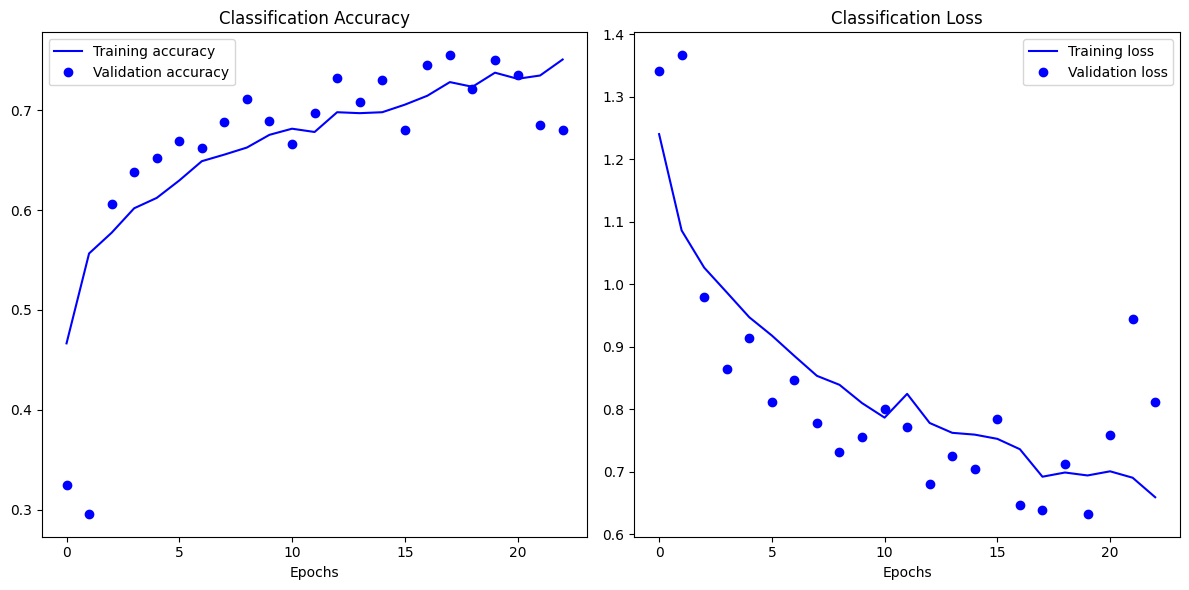

In [28]:
plot_acc_loss_classification(history)

In [59]:
def plot_metrics_large(history):
    """
    Plots the training and validation history for all available metrics
    (loss, accuracy, custom metrics) for both segmentation and classification.

    Args:
        history (tf.keras.callbacks.History): The history object returned by model.fit().
    """
    # Identify all metric names present in the history keys, excluding 'val_' prefixes
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    
    # Iterate through each base metric (e.g., 'loss', 'segmentation_dice_coefficient')
    for m in metrics:
        # Create a new figure for each metric plot
        plt.figure(figsize=(10,6))
        
        # Plot the training metric (blue line)
        plt.plot(history.history[m], 'b', label=f'Training {m}')
        
        # Construct the validation metric name (e.g., 'val_loss')
        val_m = 'val_' + m
        
        # Check if the corresponding validation metric exists
        if val_m in history.history:
            # Plot the validation metric (red line)
            plt.plot(history.history[val_m], 'r', label=f'Validation {m}')
            
        # Set plot title, labels, and display legend
        plt.title(m)
        plt.xlabel('Epochs')
        plt.ylabel(m)
        plt.legend()
        plt.show()

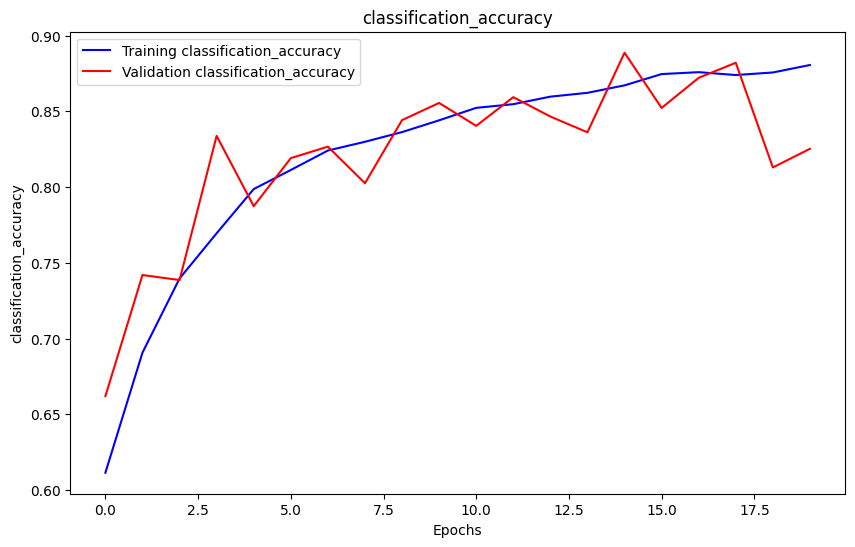

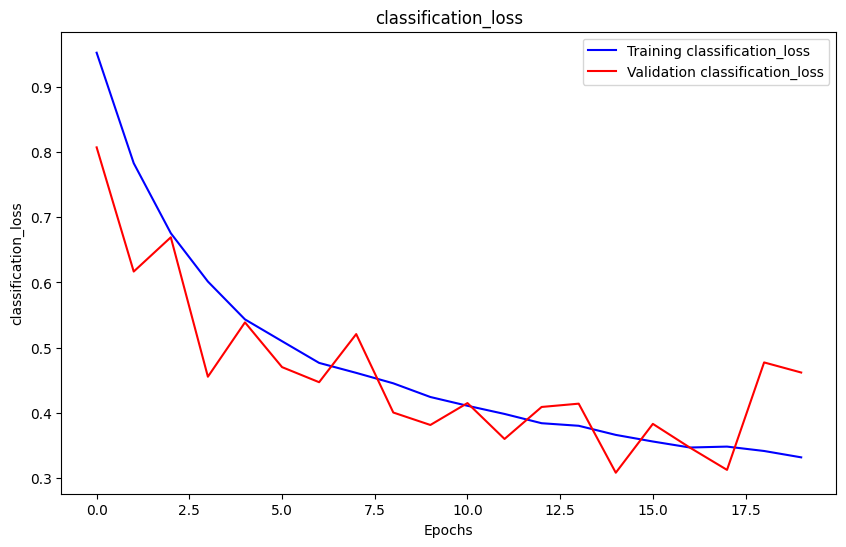

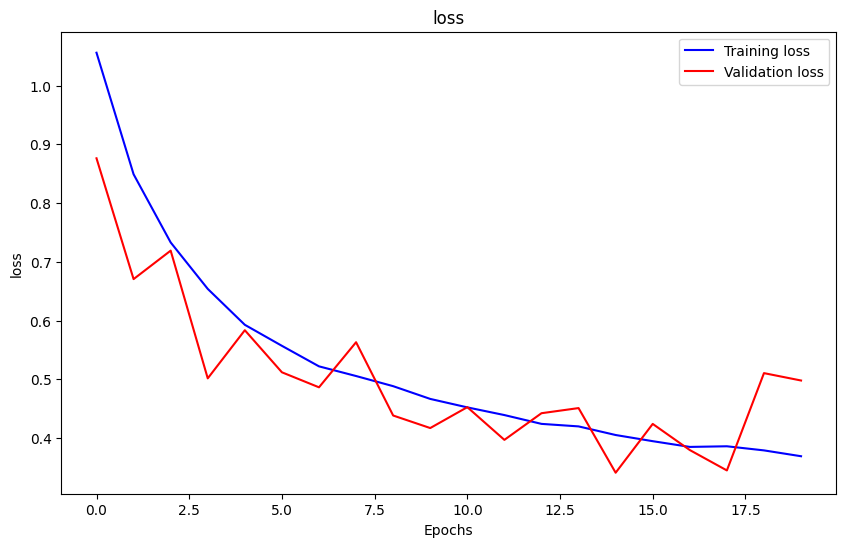

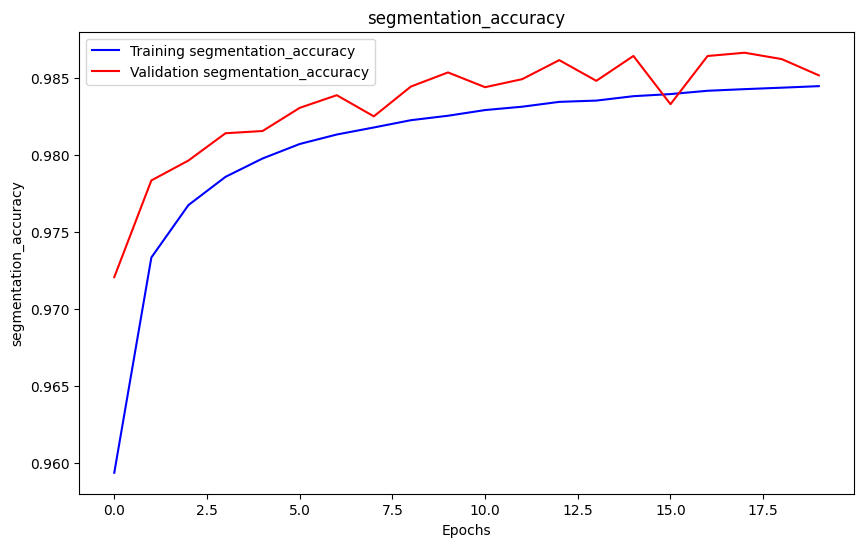

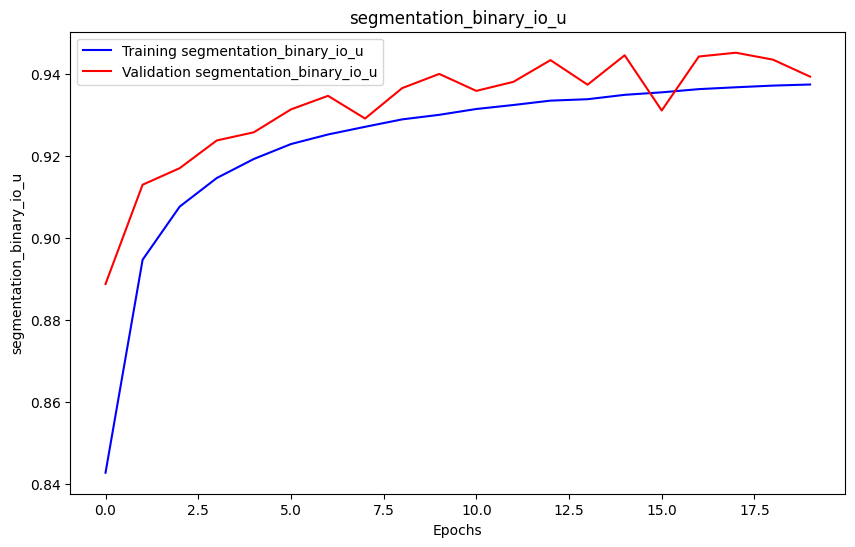

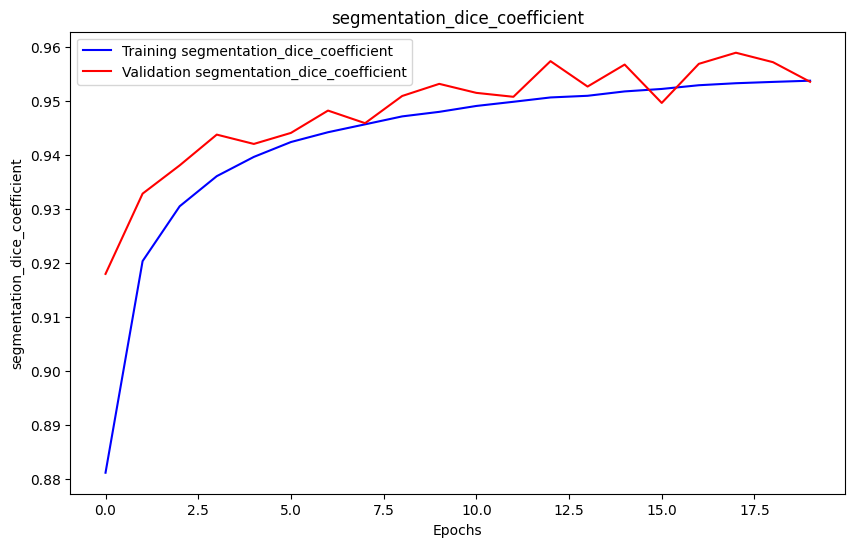

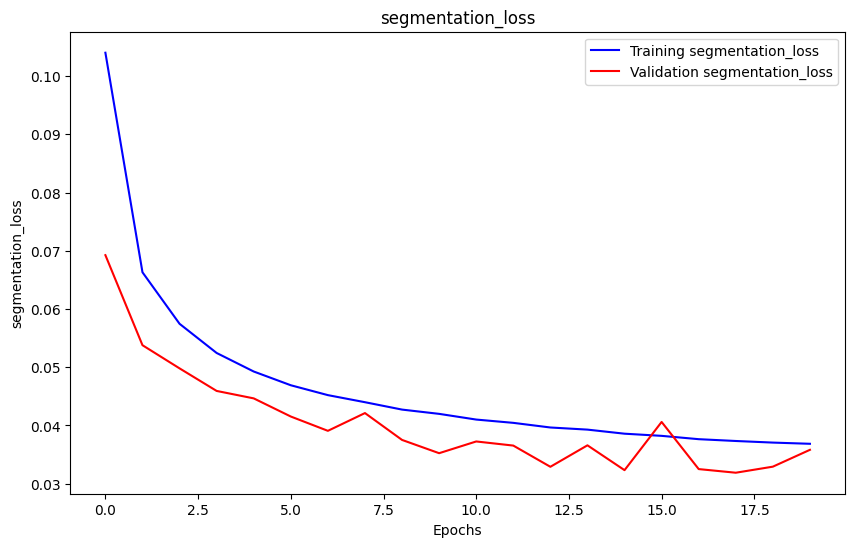

In [60]:
plot_metrics_large(history)